In [34]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor 
import matplotlib.pyplot as plt
import os.path
from os import path
from sklearn.neural_network import MLPRegressor
import seaborn as sns

In [96]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor 
import matplotlib.pyplot as plt
import os.path
from os import path
from sklearn.neural_network import MLPRegressor

def LoadRawVariables():
    c2pt = []
    ts   = []
    taus = []
    xs   = []
    ys   = []
    zs   = []
    c3pt_S = []
    c3pt_V = []
    c3pt_A = []
    c2pt_OTHER = []
    sample_num = []
    
    
    for tau in range(0, 49, 8):
        for x in range(0, 25, 8):
            for y in range(0, 25, 8):
                for z in range(0, 25, 8):
                    for sample in range(748, 1421, 16):
                        fname = "../Data/T" + str(tau) + "/x" + str(x) + "y" + str(y) + "z" + str(z) + "/nuc3pt.dat." + str(sample)
                        if path.exists(fname):
                            with open(fname) as fp:
                                for i, line in enumerate(fp):
                                    if i >= 7 and i <= 70:           # The start of Gauss -> Point 2pt correlation functions
                                        c2pt_OTHER.append([float(x) for x in line.rstrip().split()[1:5]])
                                    if i >= 5182 and i <= 5245:      # The start of Gauss -> Gauss 2pt correlation functions
                                        c2pt.append([float(x) for x in line.rstrip().split()[1:5]])
                                        ts.append(i - 5182)
                                        taus.append(tau)
                                        sample_num.append(sample)
                                        xs.append(x)
                                        ys.append(y)
                                        zs.append(z)
                                    elif i >= 10154 and i <= 10217:
                                        c3pt_S.append([float(x) for x in line.rstrip().split()[1:5]])
                                    elif i >= 10229 and i <= 10292:
                                        c3pt_V.append([float(x) for x in line.rstrip().split()[1:5]])
                                    elif i >= 19979 and i <= 20042:
                                        c3pt_A.append([float(x) for x in line.rstrip().split()[1:5]])
                                    elif i > 20042:
                                        break
    
    return ts, taus, xs, ys, zs, c2pt, c3pt_S, c3pt_V, c3pt_A, c2pt_OTHER, sample_num

ts, taus, xs, ys, zs, c2pt, c3pt_S, c3pt_V, c3pt_A, c2pt_OTHER, sample_num = LoadRawVariables()

c2pt_factor_raw = sum(np.array(c2pt)) / len(c2pt)
N_factor = np.sqrt(c2pt_factor_raw[0] ** 2 + c2pt_factor_raw[1] ** 2)

for i in range(len(c2pt)):
    for j in range(len(c2pt[i])):
        c2pt_OTHER[i][j] /= N_factor
        c2pt[i][j] /= N_factor
    for j in range(len(c3pt_S[i])):
        c3pt_S[i][j] /= N_factor
        c3pt_V[i][j] /= N_factor
        c3pt_A[i][j] /= N_factor

## Features is a <# Data> x <Size Data> 2D array for all  lists of features (same for each time slice)
## Labels is a 64 x <# Data> 2D array for all 64 sets of lists of labels

features_unshifted = np.array([[taus[i]] + [c2pt[i + j][0] for j in range(64)] + [c2pt[i + j][1] for j in range(64)] for i in range(0, len(ts), 64)])
features = []

labels_S_up = np.array([[c3pt_S[i+j][0] for i in range(0, len(c3pt_S), 64)] for j in range(64)])
labels_A_up = np.array([[c3pt_A[i+j][0] for i in range(0, len(c3pt_A), 64)] for j in range(64)])
labels_V_up = np.array([[c3pt_V[i+j][0] for i in range(0, len(c3pt_V), 64)] for j in range(64)])

labels_S_down = np.array([[c3pt_S[i+j][2] for i in range(0, len(c3pt_S), 64)] for j in range(64)])
labels_A_down = np.array([[c3pt_A[i+j][2] for i in range(0, len(c3pt_A), 64)] for j in range(64)])
labels_V_down = np.array([[c3pt_V[i+j][2] for i in range(0, len(c3pt_V), 64)] for j in range(64)])

for i in range(len(features_unshifted)):
    shift = int(features_unshifted[i, 0])
    features.append(np.append(np.roll(features_unshifted[i, 1:65], -shift), np.roll(features_unshifted[i, 65:], -shift)))
    labels_S_up[:, i] = np.roll(labels_S_up[:, i], -shift)
    labels_A_up[:, i] = np.roll(labels_A_up[:, i], -shift)
    labels_V_up[:, i] = np.roll(labels_V_up[:, i], -shift)
    labels_S_down[:, i] = np.roll(labels_S_down[:, i], -shift)
    labels_A_down[:, i] = np.roll(labels_A_down[:, i], -shift)
    labels_V_down[:, i] = np.roll(labels_V_down[:, i], -shift)

features = np.array(features)


def shuffle64Block(arr, perm):
    new_arr = arr.reshape((len(arr) // 64, 64))
    np.take(new_arr, perm, axis=0, out=new_arr)
    return new_arr.reshape(len(new_arr) * 64)

f_len = features.shape[0]

# perm = np.append(np.append(np.append(np.append(np.arange(0, f_len, 5), np.arange(1, f_len, 5)), np.arange(2, f_len, 5)), np.arange(3, f_len, 5)), np.arange(4, f_len, 5))
perm = np.random.permutation(f_len)
print(perm)
np.take(features, perm, axis=0, out=features)
np.take(labels_S_up, perm, axis=1, out=labels_S_up)
np.take(labels_A_up, perm, axis=1, out=labels_A_up)
np.take(labels_V_up, perm, axis=1, out=labels_V_up)
np.take(labels_S_down, perm, axis=1, out=labels_S_down)
np.take(labels_A_down, perm, axis=1, out=labels_A_down)
np.take(labels_V_down, perm, axis=1, out=labels_V_down)
xs = shuffle64Block(np.array(xs), perm)
ys = shuffle64Block(np.array(ys), perm)
zs = shuffle64Block(np.array(zs), perm)
ts = shuffle64Block(np.array(ts), perm)
taus = shuffle64Block(np.array(taus), perm)
sample_num = shuffle64Block(np.array(sample_num), perm)

[1257 1360 3125 ...  539 3128  734]


In [3]:
print(len(ts))

279552


## Scalar charge no Bias Correction

In [97]:
labelFrac = 0.2

labelEnd = int(len(labels_S_up[0]) * labelFrac)

X_train, Y_train_up, Y_train_down = features[:labelEnd], labels_S_up[:, :labelEnd], labels_S_down[:, :labelEnd]
X_test, Y_test_up, Y_test_down = features[labelEnd:], labels_S_up[:, labelEnd:], labels_S_down[:, labelEnd:]

gbr_up = list(range(64))
gbr_down = list(range(64))
for i in range(64):
    gbr_up[i] = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
    gbr_up[i].fit(X_train, Y_train_up[i])
    
    gbr_down[i] = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
    gbr_down[i].fit(X_train, Y_train_down[i])

Prediction quality @ t=0: 0.8250171703370132


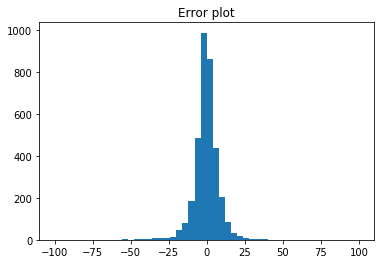

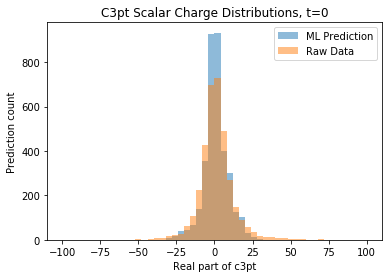

Prediction quality @ t=1: 0.7506042553457759


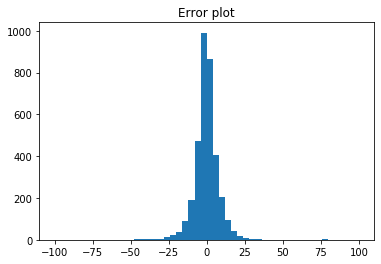

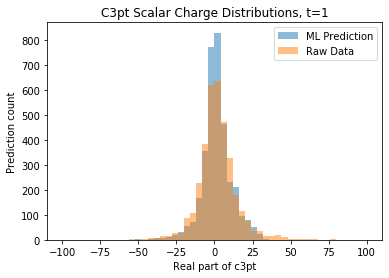

Prediction quality @ t=2: 0.7268145807854983


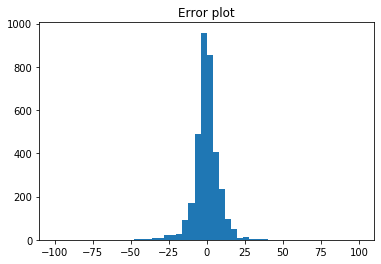

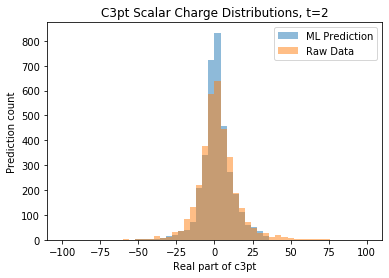

Prediction quality @ t=3: 0.7084413618075539


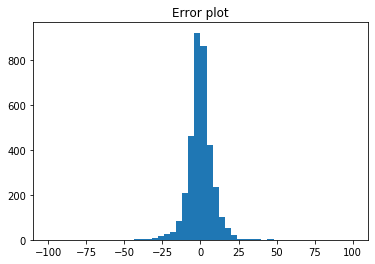

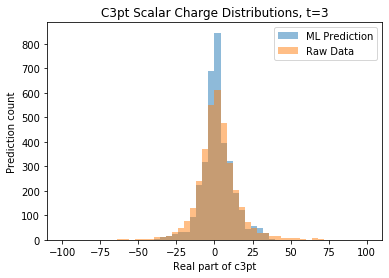

Prediction quality @ t=4: 0.7069207448025407


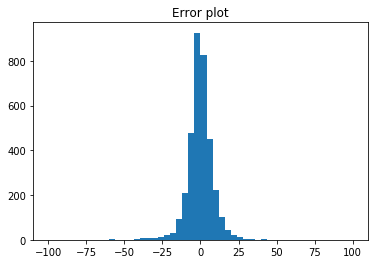

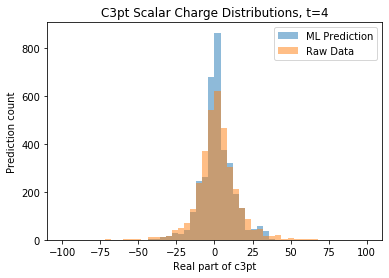

Prediction quality @ t=5: 0.7071166732777828


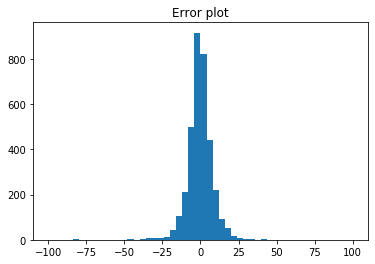

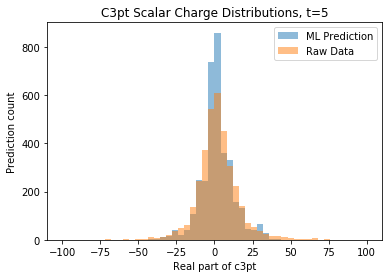

Prediction quality @ t=6: 0.696267699709953


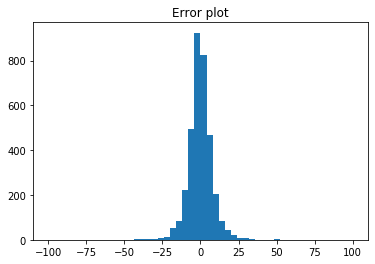

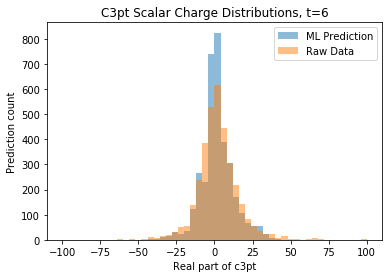

Prediction quality @ t=7: 0.6998577092088301


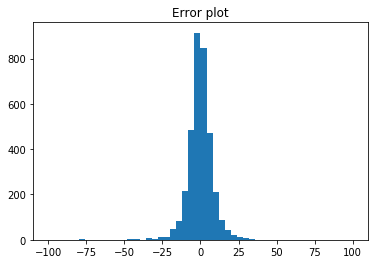

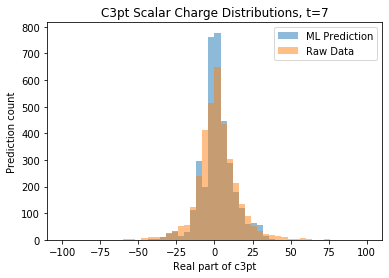

Prediction quality @ t=8: 0.7082936311226591


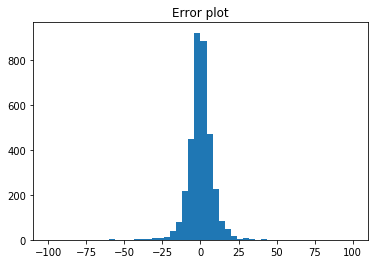

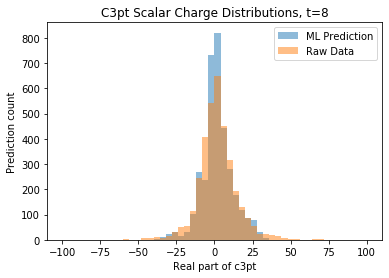

Prediction quality @ t=9: 0.7640748954282808


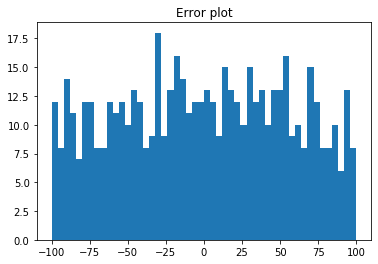

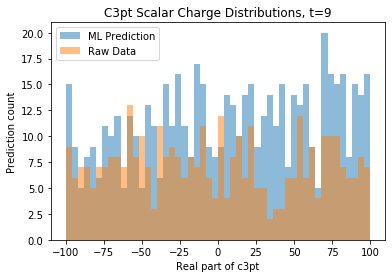

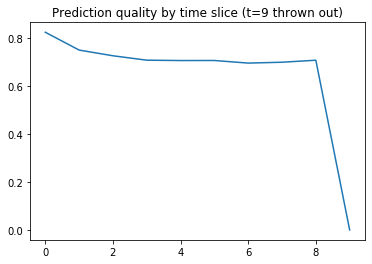

In [98]:
for t in range(samps):
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test)):
        testImg = X_test[i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg])
        errors.append(pred_up[0] - testLabel_up)
        DM_samples.append(testLabel_up)
        ML_samples.append(pred_up[0])

    print("Prediction quality @ t=" + str(t) + ":", np.std(errors) / np.std(Y_train_up[t]))
    
    plt.hist(errors, bins=50, range=[-100, 100])
    plt.title("Error plot")
    plt.show()

    plt.hist(ML_samples, bins=50, range=[-100, 100], alpha=0.5)
    plt.hist(DM_samples, bins=50, range=[-100, 100], alpha=0.5)
    plt.legend(["ML Prediction", "Raw Data"])
    plt.xlabel("Real part of c3pt")
    plt.ylabel("Prediction count")
    plt.title("C3pt Scalar Charge Distributions, t=" + str(t))
    plt.show()

quals = []
for t in range(0, samps):
    if t % 8 == 1 and t != 1:
        quals.append(0)
        continue
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test)):
        testImg = X_test[i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg])
        errors.append(pred_up[0] - testLabel_up)
        ML_samples.append(pred_up[0])
        DM_samples.append(testLabel_up)

    quals.append(np.std(errors) / np.std(Y_train_up[t]))
    
for i in range(9, samps - 1, 8):
    quals[i] = (quals[i-1] + quals[i + 1]) / 2

plt.plot(list(range(samps)), quals)
plt.title("Prediction quality by time slice (t=9 thrown out)")
plt.show()

0.7268767233375257


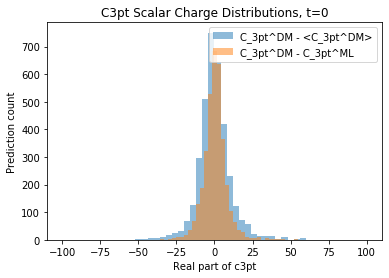

0.6616963133562048


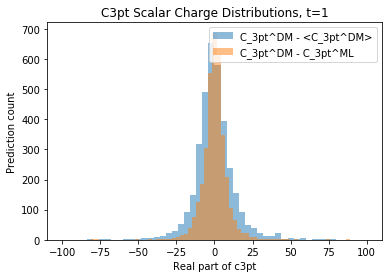

0.6523327723871976


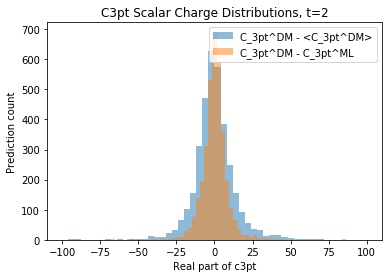

0.6398006772220185


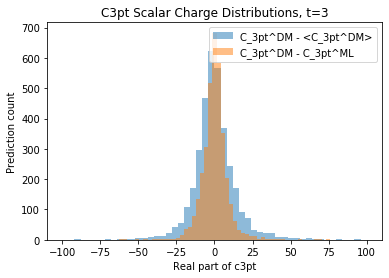

0.6352865269752851


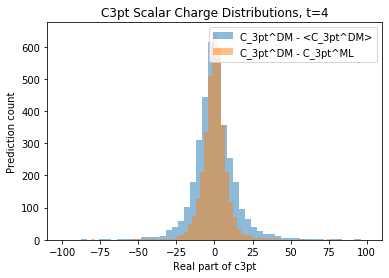

0.6314715613871502


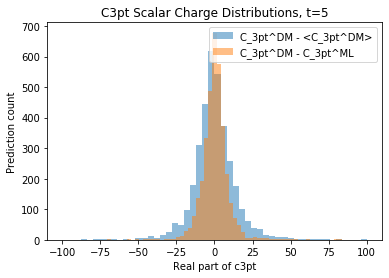

0.6201986694859826


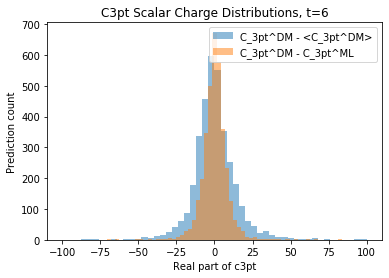

0.6193229299491226


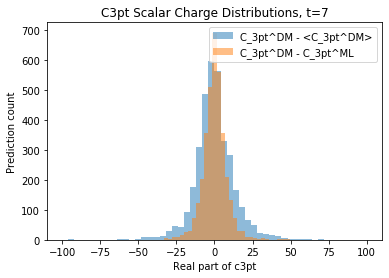

0.6225270580782505


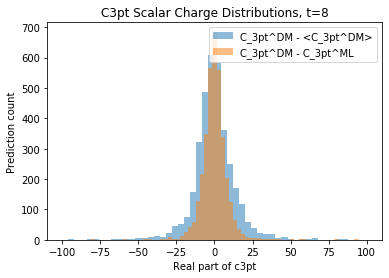

0.671982995955292


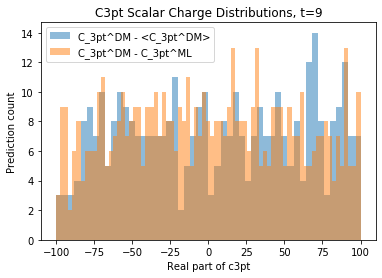

In [99]:
for t in range(samps):
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test)):
        testImg = X_test[i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg])
        errors.append(testLabel_up - pred_up[0])
        DM_samples.append(testLabel_up)
        
    DM_avg = np.average(np.array(DM_samples))
    for i in range(len(DM_samples)):
        DM_samples[i] -= DM_avg
        
    print(np.std(errors) / np.std(Y_test_up[t]))

    plt.hist(DM_samples, bins=50, range=[-100, 100], alpha=0.5)
    plt.hist(errors, bins=75, range=[-100, 100], alpha=0.5)
    plt.legend(["C_3pt^DM - <C_3pt^DM>", "C_3pt^DM - C_3pt^ML"])
    plt.xlabel("Real part of c3pt")
    plt.ylabel("Prediction count")
    plt.title("C3pt Scalar Charge Distributions, t=" + str(t))
    plt.show()

Relative Difference at t= 1 : 0.4664189132392338
Relative Difference at t= 2 : 0.1414293673893849
Relative Difference at t= 3 : 0.03348414498259092
Relative Difference at t= 4 : 0.22203276808135383
Relative Difference at t= 5 : 0.6979497290619309
Relative Difference at t= 6 : 0.4592228373697282
Relative Difference at t= 7 : 0.4620715663793884
Relative Difference at t= 8 : 0.33869306782052


Text(0.5, 1.0, 'Non Bias Corrected Prediction Comparisons')

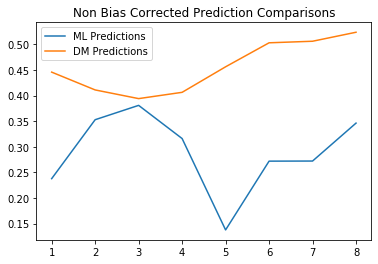

In [100]:
ML_pts = []
DM_pts = []
for t in range(1, 9, 1):
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test)):
        testImg = X_test[i]
        testLabel_down = Y_test_down[t][i]
        testLabel_up = Y_test_up[t][i]
        pred_down = gbr_down[t].predict([testImg])[0]
        pred_up = gbr_up[t].predict([testImg])[0]
        DM_samples.append(testLabel_up - testLabel_down)
        ML_samples.append(pred_up - pred_down)
        
    DM_avg = np.average(np.array(DM_samples))
    ML_avg = np.average(np.array(ML_samples))
    
    print("Relative Difference at t=", t, ":", (DM_avg - ML_avg) / DM_avg)
    ML_pts.append(ML_avg)
    DM_pts.append(DM_avg)

plt.plot(list(range(1, 9)), ML_pts)
plt.plot(list(range(1, 9)), DM_pts)
plt.legend(["ML Predictions", "DM Predictions"])
plt.title("Non Bias Corrected Prediction Comparisons")

## Scalar charge with Bias Correction

In [119]:
labelFrac = 0.2
bcFrac = 0.3
samps = 10

labelEnd = int(len(labels_S_up[0]) * labelFrac)
bcEnd = int(len(labels_S_up[0]) * (labelFrac + bcFrac))

X_train, Y_train_up, Y_train_down = features[:labelEnd], labels_S_up[:, :labelEnd], labels_S_down[:, :labelEnd]
X_bc, Y_bc_up, Y_bc_down = features[labelEnd:bcEnd], labels_S_up[:, labelEnd:bcEnd], labels_S_down[:, labelEnd:bcEnd]
X_test, Y_test_up, Y_test_down = features[bcEnd:], labels_S_up[:, bcEnd:], labels_S_down[:, bcEnd:]

gbr_up = list(range(64))
gbr_down = list(range(64))
biasCrxn_up = list(range(64))
biasCrxn_down = list(range(64))
for i in range(samps):
    gbr_up[i] = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
    gbr_up[i].fit(X_train, Y_train_up[i])
    pred_up = gbr_up[i].predict(X_bc)
    biasCrxn_up[i] = np.average(Y_bc_up[i] - pred_up)
    print("Bias Correction up at t=", i, ":", biasCrxn_up[i])
    
    gbr_down[i] = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
    gbr_down[i].fit(X_train, Y_train_down[i])
    pred_down = gbr_down[i].predict(X_bc)
    biasCrxn_down[i] = np.average(Y_bc_down[i] - pred_down)
    print("Bias Correction down at t=", i, ":", biasCrxn_down[i])

Bias Correction up at t= 0 : 0.14452827375130844
Bias Correction down at t= 0 : -0.09018401657102222
Bias Correction up at t= 1 : 0.10419887869031548
Bias Correction down at t= 1 : -0.08729762574597633
Bias Correction up at t= 2 : 0.00307817622523455
Bias Correction down at t= 2 : -0.05452922263790381
Bias Correction up at t= 3 : -0.12449814802060237
Bias Correction down at t= 3 : -0.11528452783683889
Bias Correction up at t= 4 : -0.028909108582346705
Bias Correction down at t= 4 : -0.06823007197253168
Bias Correction up at t= 5 : 0.16746344604829624
Bias Correction down at t= 5 : -0.11476806641181365
Bias Correction up at t= 6 : 0.10733415586176366
Bias Correction down at t= 6 : -0.13221805659346458
Bias Correction up at t= 7 : 0.16666080177620335
Bias Correction down at t= 7 : -0.16471735357761147
Bias Correction up at t= 8 : 0.01812419719078253
Bias Correction down at t= 8 : -0.21785607274987603
Bias Correction up at t= 9 : 2.2920071870979215
Bias Correction down at t= 9 : -21.88707

Prediction quality @ t=0: 0.8081251236044469


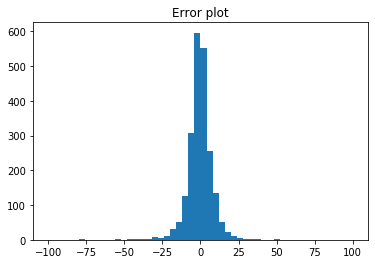

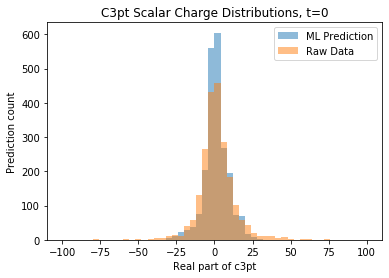

Prediction quality @ t=1: 0.7467785528973326


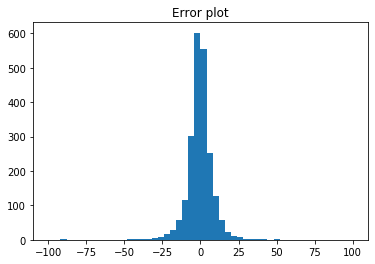

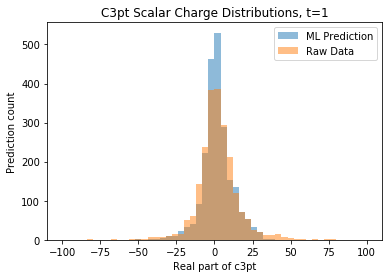

Prediction quality @ t=2: 0.722953755089878


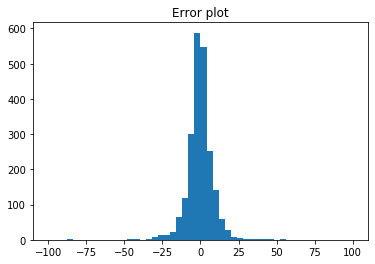

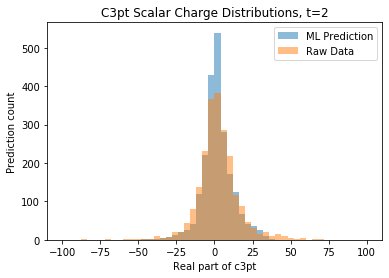

Prediction quality @ t=3: 0.7100059902539438


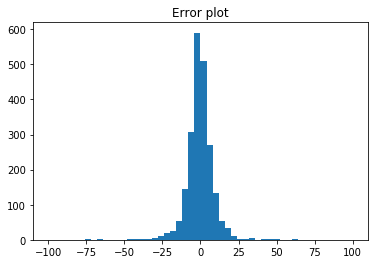

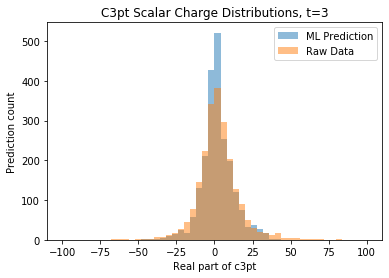

Prediction quality @ t=4: 0.7146329967036513


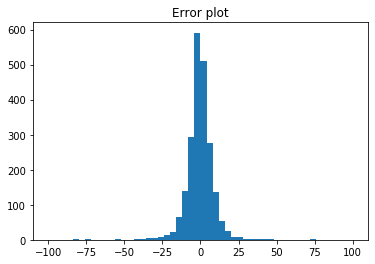

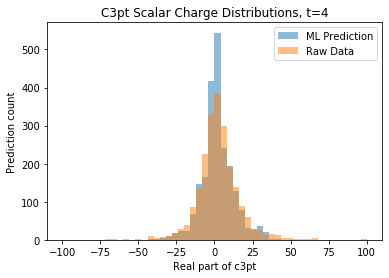

Prediction quality @ t=5: 0.7200842280567681


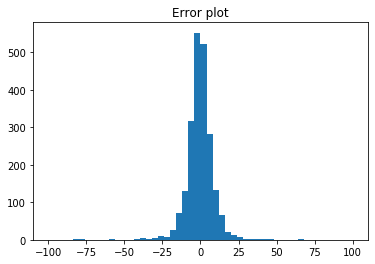

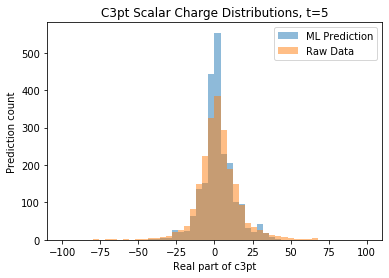

Prediction quality @ t=6: 0.7098577690912854


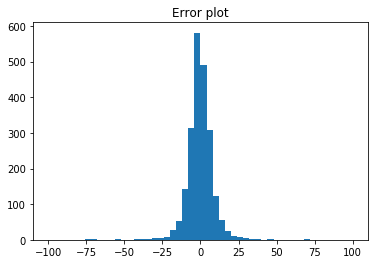

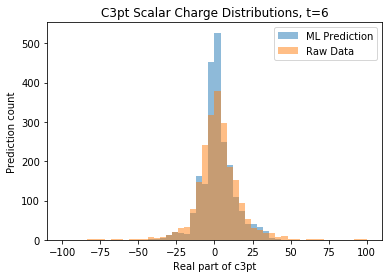

Prediction quality @ t=7: 0.7167877091467844


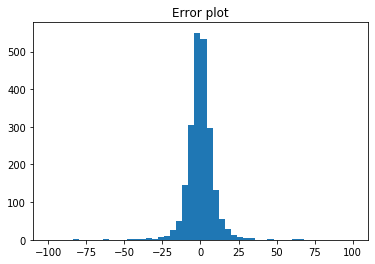

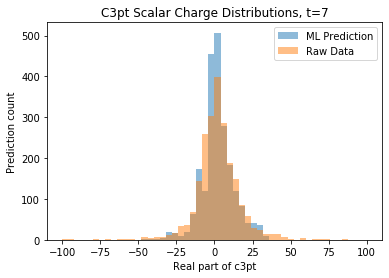

Prediction quality @ t=8: 0.7194597227510094


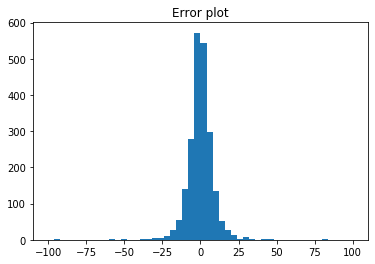

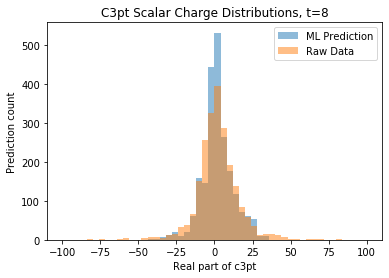

Prediction quality @ t=9: 0.7745207931460588


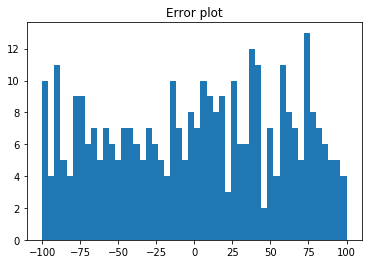

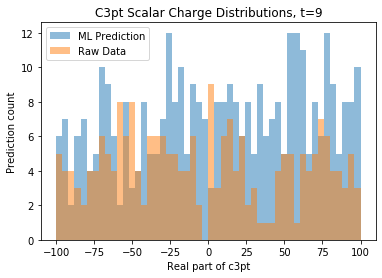

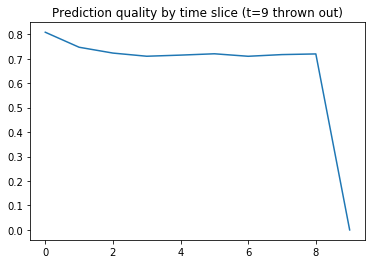

In [120]:
for t in range(samps):
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test)):
        testImg = X_test[i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg])[0] + biasCrxn_up[t]
        errors.append(pred_up - testLabel_up)
        DM_samples.append(testLabel_up)
        ML_samples.append(pred_up)

    print("Prediction quality @ t=" + str(t) + ":", np.std(errors) / np.std(Y_train_up[t]))
    
    plt.hist(errors, bins=50, range=[-100, 100])
    plt.title("Error plot")
    plt.show()

    plt.hist(ML_samples, bins=50, range=[-100, 100], alpha=0.5)
    plt.hist(DM_samples, bins=50, range=[-100, 100], alpha=0.5)
    plt.legend(["ML Prediction", "Raw Data"])
    plt.xlabel("Real part of c3pt")
    plt.ylabel("Prediction count")
    plt.title("C3pt Scalar Charge Distributions, t=" + str(t))
    plt.show()

quals = []
for t in range(0, samps):
    if t % 8 == 1 and t != 1:
        quals.append(0)
        continue
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test)):
        testImg = X_test[i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg])[0] + biasCrxn_up[t]
        errors.append(pred_up - testLabel_up)
        ML_samples.append(pred_up)
        DM_samples.append(testLabel_up)

    quals.append(np.std(errors) / np.std(Y_train_up[t]))
    
for i in range(9, samps - 1, 8):
    quals[i] = (quals[i-1] + quals[i + 1]) / 2

plt.plot(list(range(samps)), quals)
plt.title("Prediction quality by time slice (t=9 thrown out)")
plt.show()

0.7130817833127132


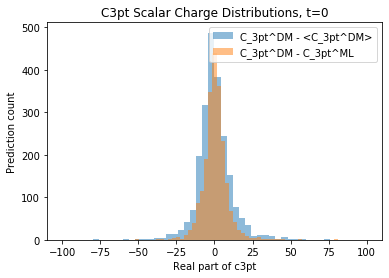

0.652681734362048


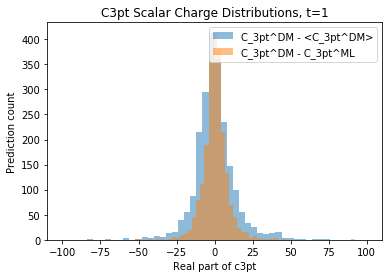

0.6402209526846986


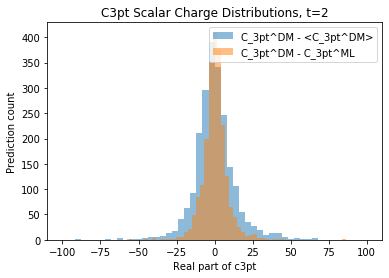

0.6318145407011486


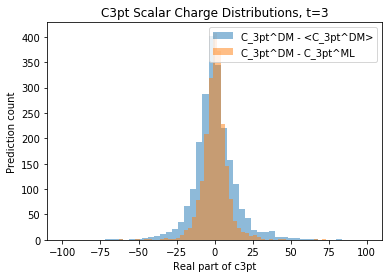

0.6335347409080336


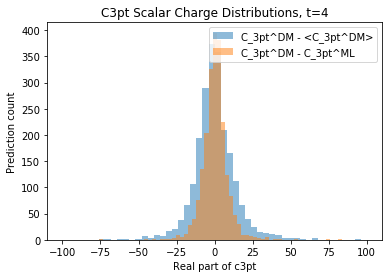

0.6345706760212729


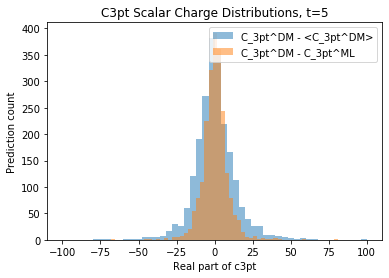

0.624388586333837


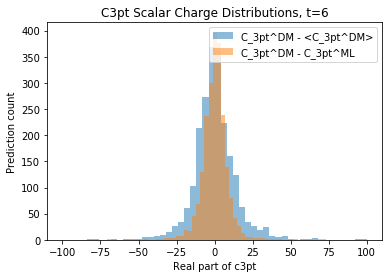

0.6278130279775296


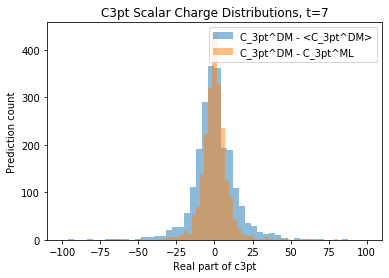

0.6249874369966222


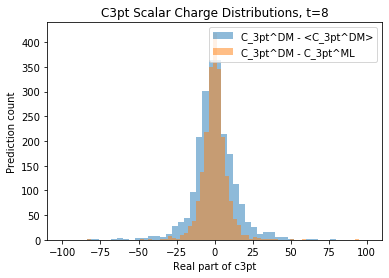

0.6681511242581326


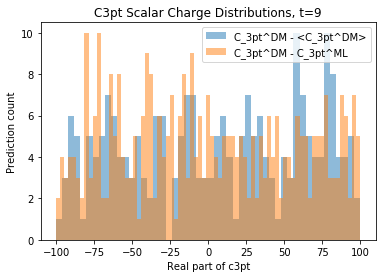

In [121]:
for t in range(samps):
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test)):
        testImg = X_test[i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg])[0] + biasCrxn_up[t]
        errors.append(testLabel_up - pred_up)
        DM_samples.append(testLabel_up)
        
    DM_avg = np.average(np.array(DM_samples))
    for i in range(len(DM_samples)):
        DM_samples[i] -= DM_avg
        
    print(np.std(errors) / np.std(Y_test_up[t]))

    plt.hist(DM_samples, bins=50, range=[-100, 100], alpha=0.5)
    plt.hist(errors, bins=75, range=[-100, 100], alpha=0.5)
    plt.legend(["C_3pt^DM - <C_3pt^DM>", "C_3pt^DM - C_3pt^ML"])
    plt.xlabel("Real part of c3pt")
    plt.ylabel("Prediction count")
    plt.title("C3pt Scalar Charge Distributions, t=" + str(t))
    plt.show()

Relative Difference at t= 1 : 0.004658786568185936
Relative Difference at t= 2 : 0.09259422782079263
Relative Difference at t= 3 : 0.11082720558428318
Relative Difference at t= 4 : 0.1331346464122846
Relative Difference at t= 5 : 0.07753622657616474
Relative Difference at t= 6 : -0.07375498795364543
Relative Difference at t= 7 : -0.21853978099813068
Relative Difference at t= 8 : -0.2252002359671116


Text(0.5, 1.0, 'Bias Corrected Scalar Prediction Comparisons')

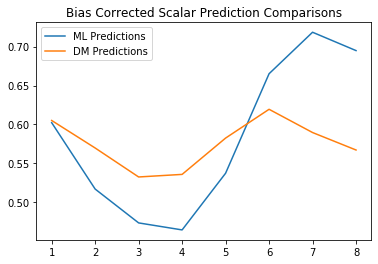

In [122]:
ML_pts = []
DM_pts = []
for t in range(1, 9, 1):
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test)):
        testImg = X_test[i]
        testLabel_down = Y_test_down[t][i]
        testLabel_up = Y_test_up[t][i]
        pred_down = gbr_down[t].predict([testImg])[0] + biasCrxn_down[t]
        pred_up = gbr_up[t].predict([testImg])[0] + biasCrxn_up[t]
        DM_samples.append(testLabel_up - testLabel_down)
        ML_samples.append(pred_up - pred_down)
        
    DM_avg = np.average(np.array(DM_samples))
    ML_avg = np.average(np.array(ML_samples))
    
    print("Relative Difference at t=", t, ":", (DM_avg - ML_avg) / DM_avg)
    ML_pts.append(ML_avg)
    DM_pts.append(DM_avg)

plt.plot(list(range(1, 9)), ML_pts)
plt.plot(list(range(1, 9)), DM_pts)
plt.legend(["ML Predictions", "DM Predictions"])
plt.title("Bias Corrected Scalar Prediction Comparisons")

## Vector Charge Prediction With Bias Correction

In [123]:
labelFrac = 0.2
bcFrac = 0.3
samps = 10

labelEnd = int(len(labels_V_up[0]) * labelFrac)
bcEnd = int(len(labels_V_up[0]) * (labelFrac + bcFrac))

X_train, Y_train_up, Y_train_down = features[:labelEnd], labels_V_up[:, :labelEnd], labels_V_down[:, :labelEnd]
X_bc, Y_bc_up, Y_bc_down = features[labelEnd:bcEnd], labels_V_up[:, labelEnd:bcEnd], labels_V_down[:, labelEnd:bcEnd]
X_test, Y_test_up, Y_test_down = features[bcEnd:], labels_V_up[:, bcEnd:], labels_V_down[:, bcEnd:]

gbr_up = list(range(64))
gbr_down = list(range(64))
biasCrxn_up = list(range(64))
biasCrxn_down = list(range(64))
for i in range(samps):
    gbr_up[i] = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
    gbr_up[i].fit(X_train, Y_train_up[i])
    pred_up = gbr_up[i].predict(X_bc)
    biasCrxn_up[i] = np.average(Y_bc_up[i] - pred_up)
    print("Bias Correction up at t=", i, ":", biasCrxn_up[i])
    
    gbr_down[i] = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
    gbr_down[i].fit(X_train, Y_train_down[i])
    pred_down = gbr_down[i].predict(X_bc)
    biasCrxn_down[i] = np.average(Y_bc_down[i] - pred_down)
    print("Bias Correction down at t=", i, ":", biasCrxn_down[i])

Bias Correction up at t= 0 : 0.006830943514460767
Bias Correction down at t= 0 : 0.0018504777681823085
Bias Correction up at t= 1 : -0.0010958993138303257
Bias Correction down at t= 1 : 0.0009319685597884716
Bias Correction up at t= 2 : 0.00944856033512463
Bias Correction down at t= 2 : 0.006400754021990805
Bias Correction up at t= 3 : 0.014123991765547125
Bias Correction down at t= 3 : 0.0070485967635505005
Bias Correction up at t= 4 : 0.0100355110183592
Bias Correction down at t= 4 : 0.0009432288596641519
Bias Correction up at t= 5 : 0.013469357308814059
Bias Correction down at t= 5 : 0.004465735040793381
Bias Correction up at t= 6 : 0.01755737660725529
Bias Correction down at t= 6 : 0.011276672091099293
Bias Correction up at t= 7 : 0.0001513680541423483
Bias Correction down at t= 7 : 0.007700678443805822
Bias Correction up at t= 8 : 0.0077249129159086515
Bias Correction down at t= 8 : 0.0026591276967145995
Bias Correction up at t= 9 : 7.313711023069026
Bias Correction down at t= 9 :

Prediction quality @ t=0: 0.30171377037224756


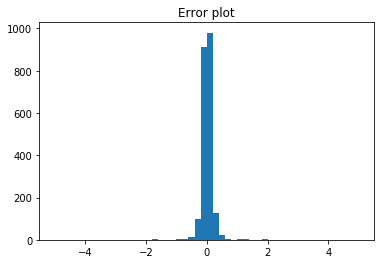

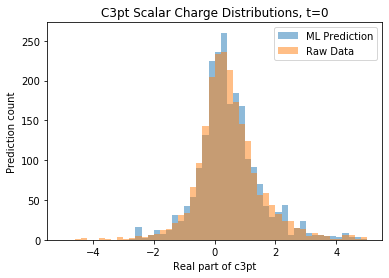

Prediction quality @ t=1: 0.2823421653391501


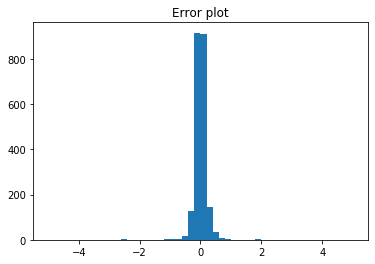

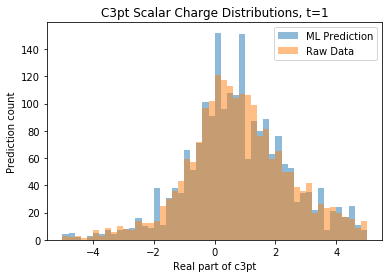

Prediction quality @ t=2: 0.2695146015576745


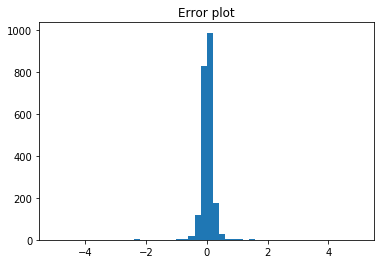

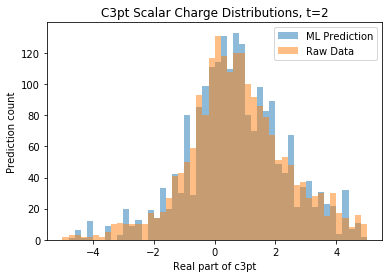

Prediction quality @ t=3: 0.28307870316087197


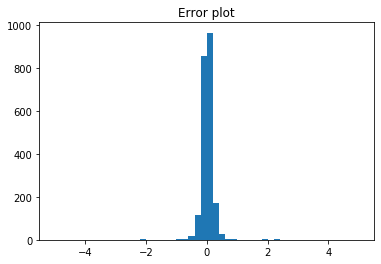

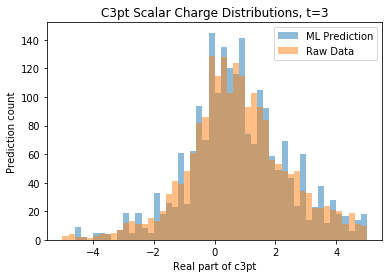

Prediction quality @ t=4: 0.2891330114177819


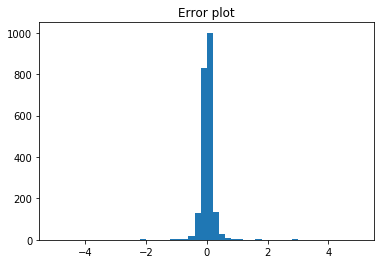

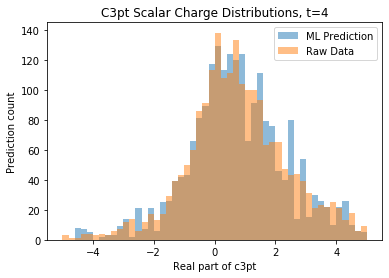

Prediction quality @ t=5: 0.2908361079561556


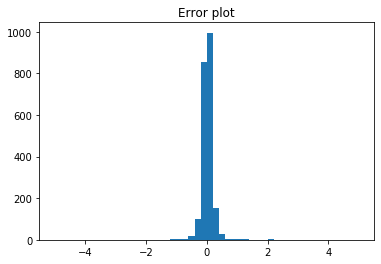

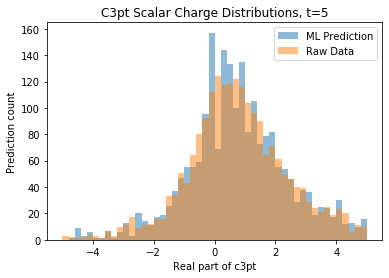

Prediction quality @ t=6: 0.28969668620976147


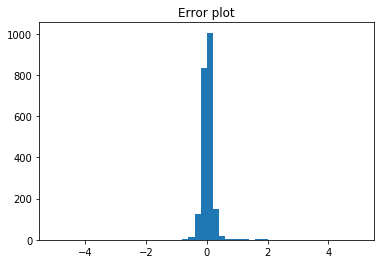

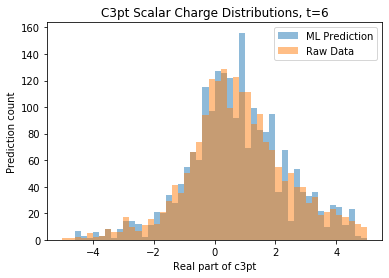

Prediction quality @ t=7: 0.28523822901256657


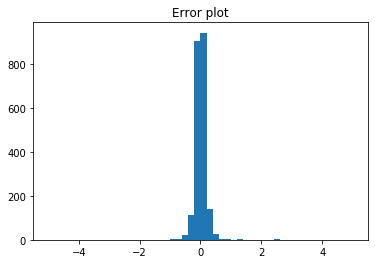

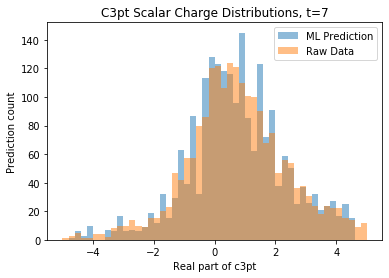

Prediction quality @ t=8: 0.28022902138470873


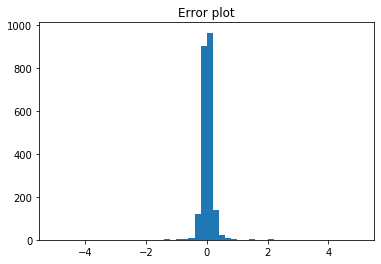

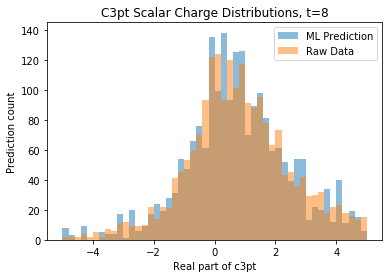

Prediction quality @ t=9: 0.5833210721675998


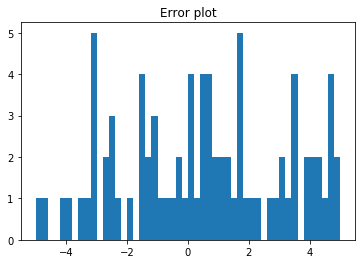

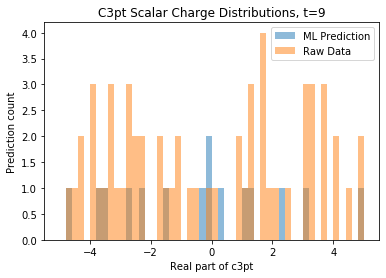

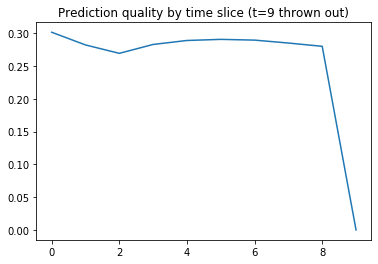

In [129]:
for t in range(samps):
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test)):
        testImg = X_test[i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg])[0] + biasCrxn_up[t]
        errors.append(pred_up - testLabel_up)
        DM_samples.append(testLabel_up)
        ML_samples.append(pred_up)

    print("Prediction quality @ t=" + str(t) + ":", np.std(errors) / np.std(Y_train_up[t]))
    
    plt.hist(errors, bins=50, range=[-5, 5])
    plt.title("Error plot")
    plt.show()

    plt.hist(ML_samples, bins=50, range=[-5, 5], alpha=0.5)
    plt.hist(DM_samples, bins=50, range=[-5, 5], alpha=0.5)
    plt.legend(["ML Prediction", "Raw Data"])
    plt.xlabel("Real part of c3pt")
    plt.ylabel("Prediction count")
    plt.title("C3pt Scalar Charge Distributions, t=" + str(t))
    plt.show()

quals = []
for t in range(0, samps):
    if t % 8 == 1 and t != 1:
        quals.append(0)
        continue
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test)):
        testImg = X_test[i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg])[0] + biasCrxn_up[t]
        errors.append(pred_up - testLabel_up)
        ML_samples.append(pred_up)
        DM_samples.append(testLabel_up)

    quals.append(np.std(errors) / np.std(Y_train_up[t]))
    
for i in range(9, samps - 1, 8):
    quals[i] = (quals[i-1] + quals[i + 1]) / 2

plt.plot(list(range(samps)), quals)
plt.title("Prediction quality by time slice (t=9 thrown out)")
plt.show()

0.2699257831689203


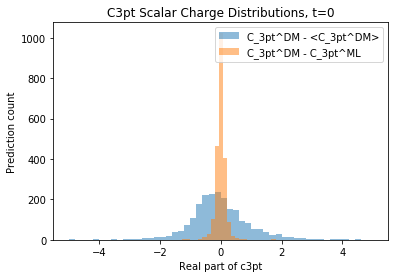

0.2484697543477545


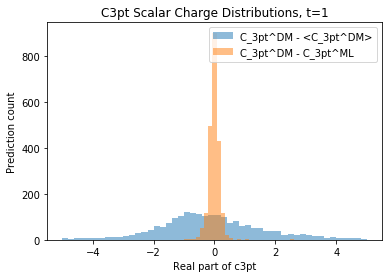

0.23921125560293732


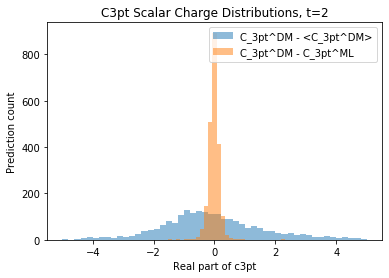

0.2502434251825026


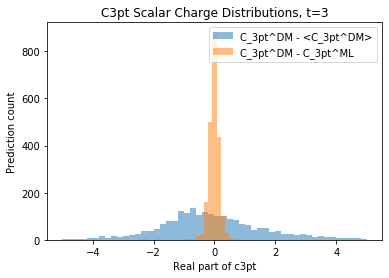

0.25482793243761215


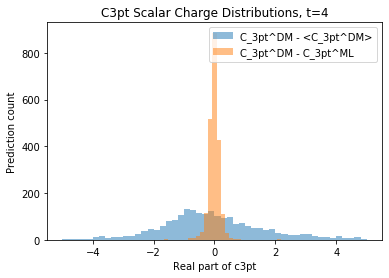

0.25591532161799246


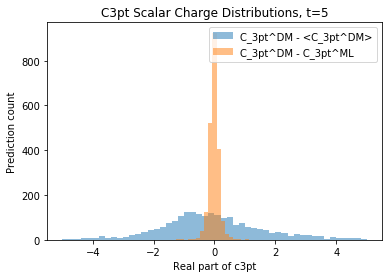

0.2544970610076984


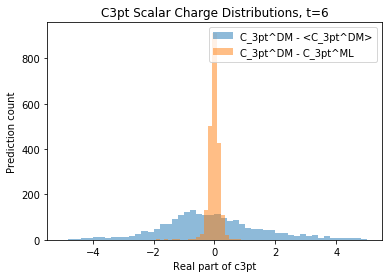

0.2509989878325336


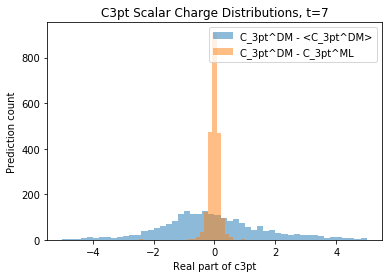

0.24584027353675053


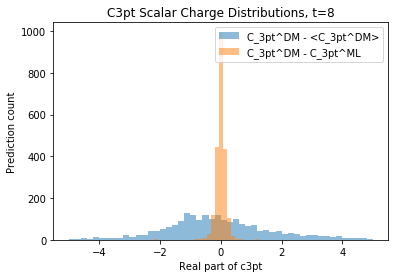

0.5001671190984989


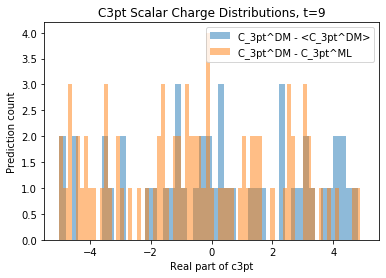

In [130]:
for t in range(samps):
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test)):
        testImg = X_test[i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg])[0] + biasCrxn_up[t]
        errors.append(testLabel_up - pred_up)
        DM_samples.append(testLabel_up)
        
    DM_avg = np.average(np.array(DM_samples))
    for i in range(len(DM_samples)):
        DM_samples[i] -= DM_avg
        
    print(np.std(errors) / np.std(Y_test_up[t]))

    plt.hist(DM_samples, bins=50, range=[-5, 5], alpha=0.5)
    plt.hist(errors, bins=75, range=[-5, 5], alpha=0.5)
    plt.legend(["C_3pt^DM - <C_3pt^DM>", "C_3pt^DM - C_3pt^ML"])
    plt.xlabel("Real part of c3pt")
    plt.ylabel("Prediction count")
    plt.title("C3pt Scalar Charge Distributions, t=" + str(t))
    plt.show()

Relative Difference at t= 1 : -0.023481830744686613
Relative Difference at t= 2 : -0.022263468825964222
Relative Difference at t= 3 : -0.008727443441247673
Relative Difference at t= 4 : -0.013799573610359644
Relative Difference at t= 5 : -0.006035867710942197
Relative Difference at t= 6 : 0.005644673899112352
Relative Difference at t= 7 : -0.0240040799789707
Relative Difference at t= 8 : 0.0003097160707187903


Text(0.5, 1.0, 'Non-Bias Corrected Vector Prediction Comparisons')

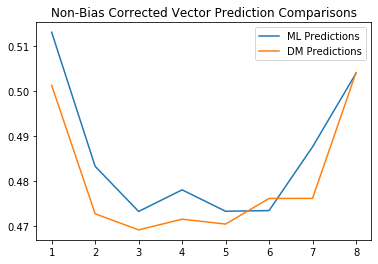

In [133]:
ML_pts = []
DM_pts = []
for t in range(1, 9, 1):
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test)):
        testImg = X_test[i]
        testLabel_down = Y_test_down[t][i]
        testLabel_up = Y_test_up[t][i]
        pred_down = gbr_down[t].predict([testImg])[0]# + biasCrxn_down[t]
        pred_up = gbr_up[t].predict([testImg])[0]# + biasCrxn_up[t]
        DM_samples.append(testLabel_up - testLabel_down)
        ML_samples.append(pred_up - pred_down)
        
    DM_avg = np.average(np.array(DM_samples))
    ML_avg = np.average(np.array(ML_samples))
    
    print("Relative Difference at t=", t, ":", (DM_avg - ML_avg) / DM_avg)
    ML_pts.append(ML_avg)
    DM_pts.append(DM_avg)

plt.plot(list(range(1, 9)), ML_pts)
plt.plot(list(range(1, 9)), DM_pts)
plt.legend(["ML Predictions", "DM Predictions"])
plt.title("Non-Bias Corrected Vector Prediction Comparisons")

## Vector Charge Prediction With No Bias Correction

In [65]:
labelFrac = 0.2

labelEnd = int(len(labels_S_up[0]) * labelFrac)

X_train, Y_train_up, Y_train_down = features[:labelEnd], labels_V_up[:, :labelEnd], labels_V_down[:, :labelEnd]
X_test, Y_test_up, Y_test_down = features[labelEnd:], labels_V_up[:, labelEnd:], labels_V_down[:, labelEnd:]

gbr_up = list(range(64))
gbr_down = list(range(64))
for i in range(64):
    gbr_up[i] = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
    gbr_up[i].fit(X_train, Y_train_up[i])
    
    gbr_down[i] = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
    gbr_down[i].fit(X_train, Y_train_down[i])

# Y_train_up_avg = np.sum(Y_train_up, axis=0) / len(Y_train_up)
# Y_train_down_avg = np.sum(Y_train_down, axis=0) / len(Y_train_down)

# gbr_up_congl.fit(X_train[0], Y_train_up_avg)
# gbr_down_congl.fit(X_train[0], Y_train_down_avg)

Prediction quality @ t=0: 0.17582483675558885


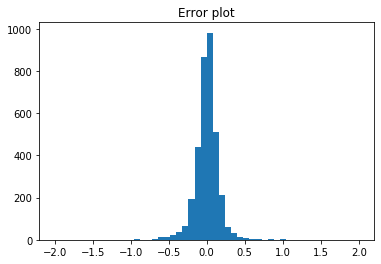

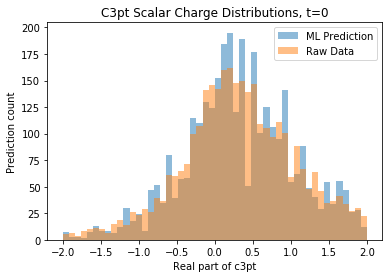

Prediction quality @ t=1: 0.1807648644530367


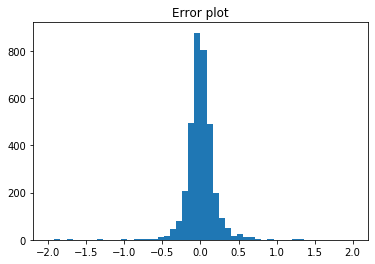

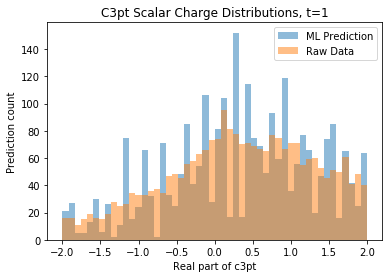

Prediction quality @ t=2: 0.1508480150045845


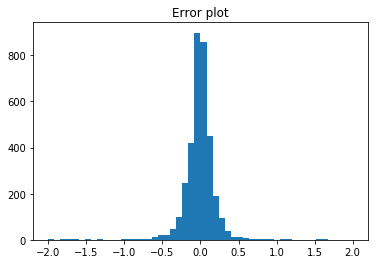

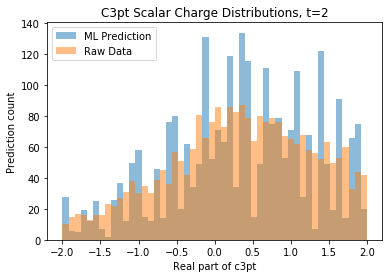

Prediction quality @ t=3: 0.1626237722793307


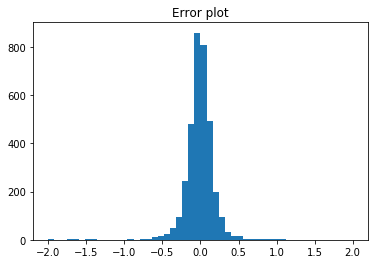

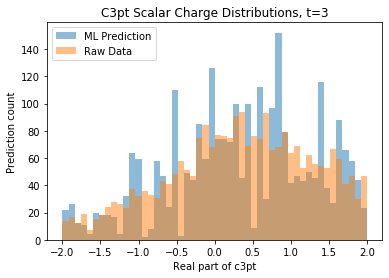

Prediction quality @ t=4: 0.1536049331415163


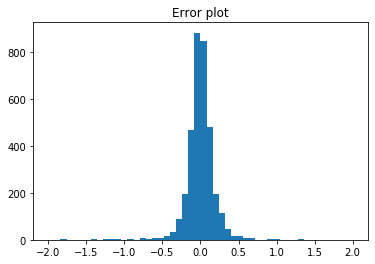

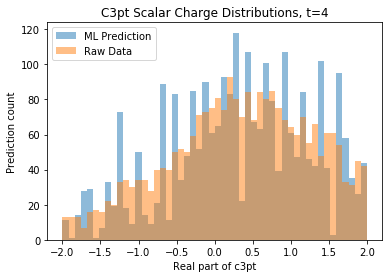

Prediction quality @ t=5: 0.1738211050695895


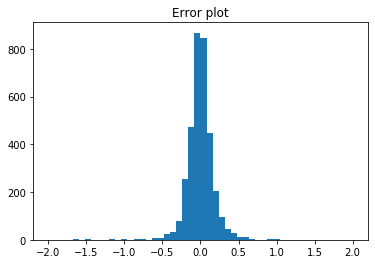

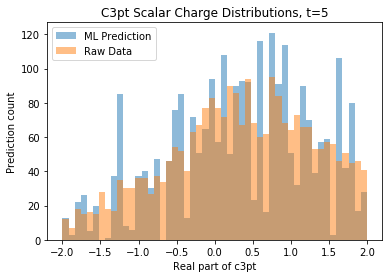

Prediction quality @ t=6: 0.16995424153792332


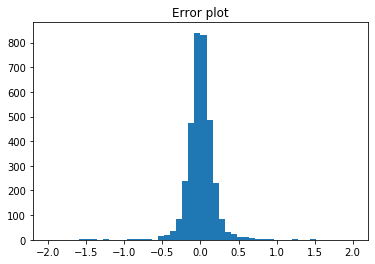

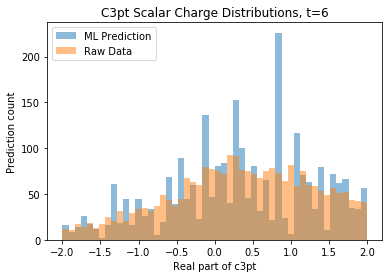

Prediction quality @ t=7: 0.14544909618943772


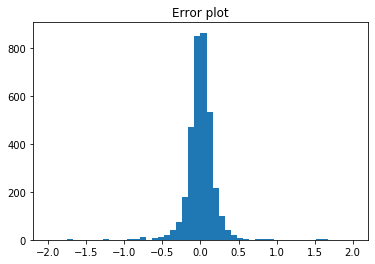

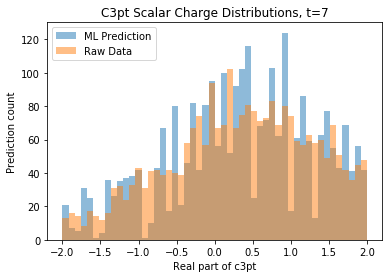

Prediction quality @ t=8: 0.13836898644152096


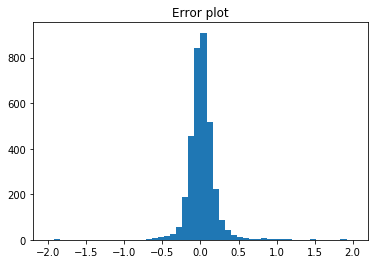

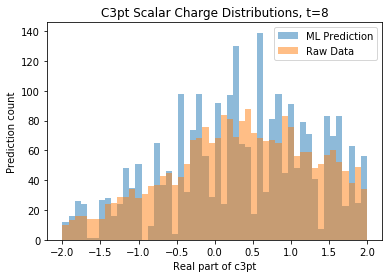

Prediction quality @ t=9: 0.5115248349694977


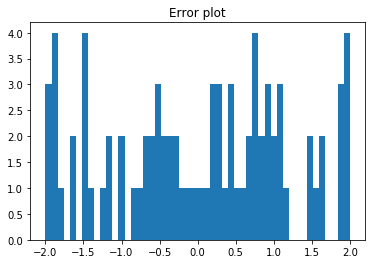

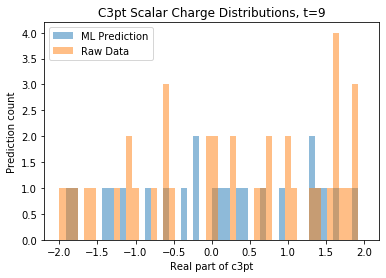

Prediction quality @ t=10: 0.6875598809733768


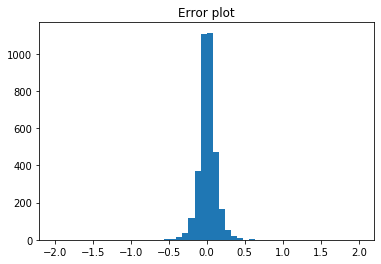

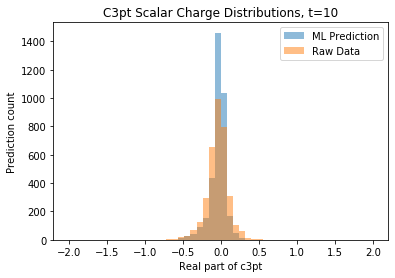

Prediction quality @ t=11: 1.084816174904202


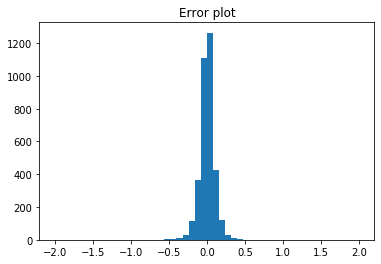

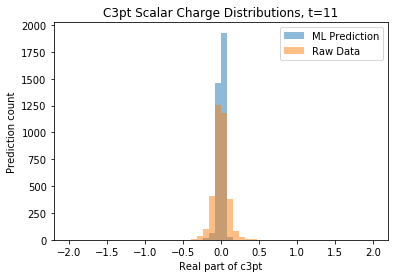

Prediction quality @ t=12: 1.039009159785705


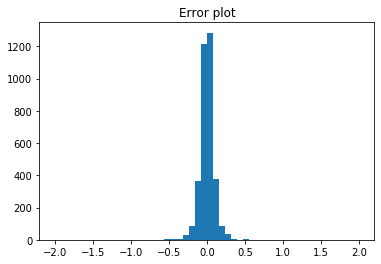

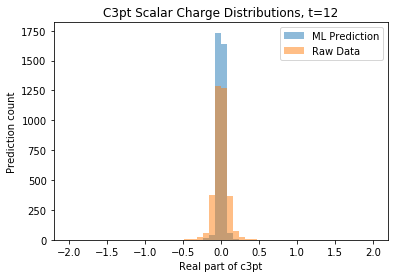

Prediction quality @ t=13: 1.0068725334064448


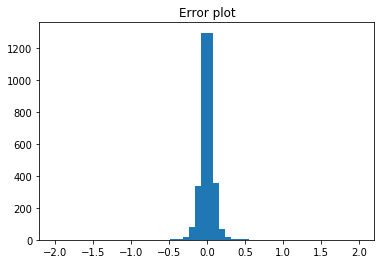

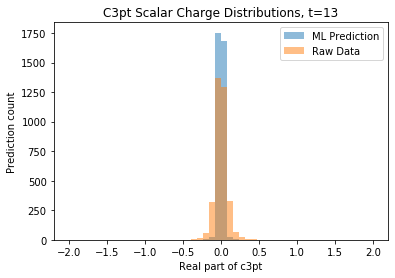

Prediction quality @ t=14: 1.0208570899942153


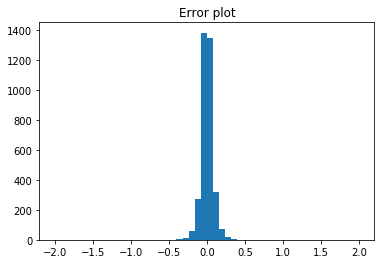

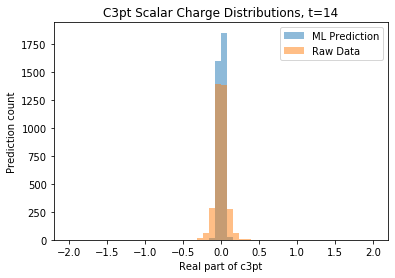

Prediction quality @ t=15: 0.9725420699125041


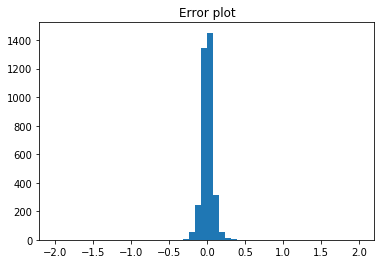

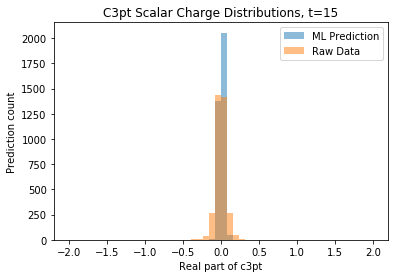

Prediction quality @ t=16: 1.0094046114868076


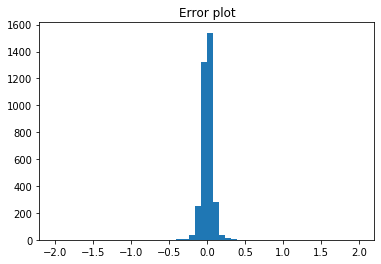

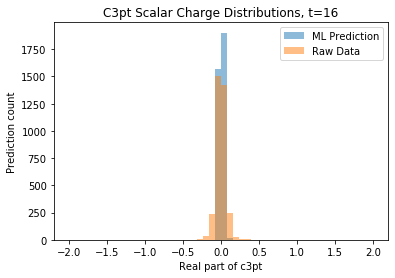

Prediction quality @ t=17: 0.9989470330867183


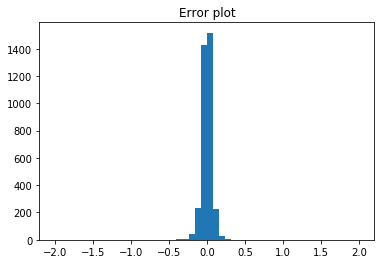

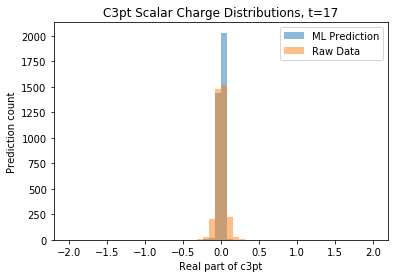

Prediction quality @ t=18: 0.9918795676110304


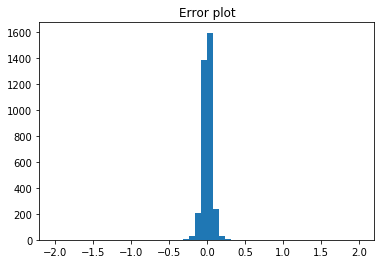

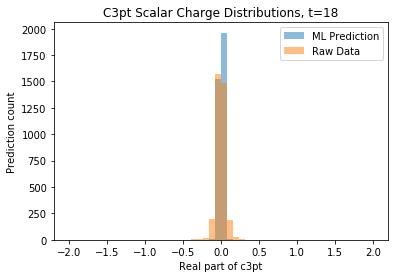

Prediction quality @ t=19: 1.0217783859008813


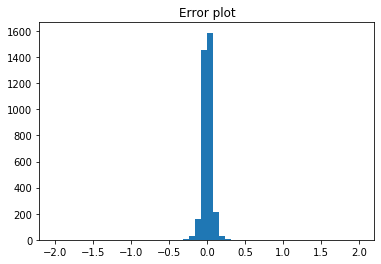

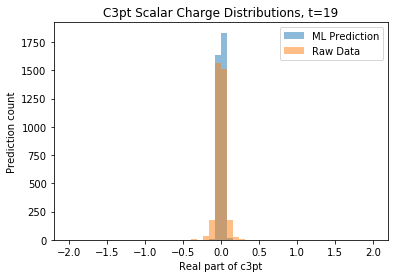

Prediction quality @ t=20: 1.0425694216487194


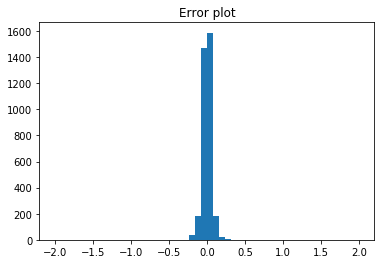

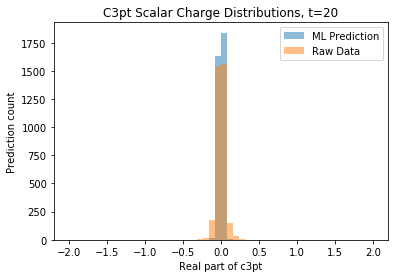

Prediction quality @ t=21: 0.992610858228432


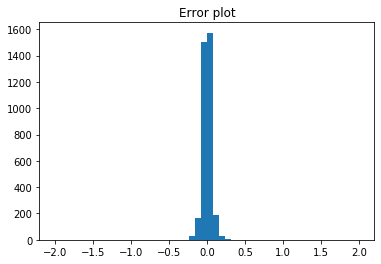

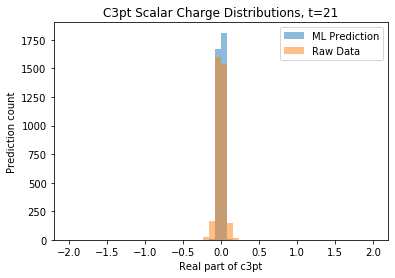

Prediction quality @ t=22: 0.9911207791931426


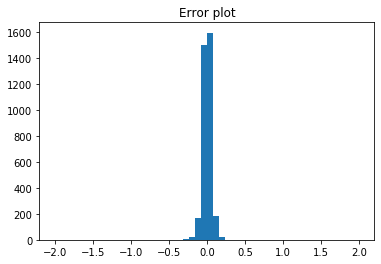

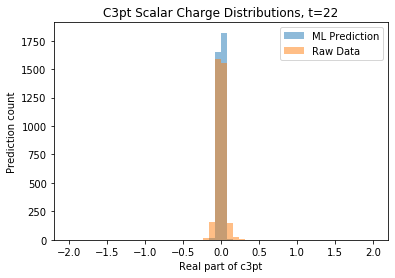

Prediction quality @ t=23: 0.9968585236679303


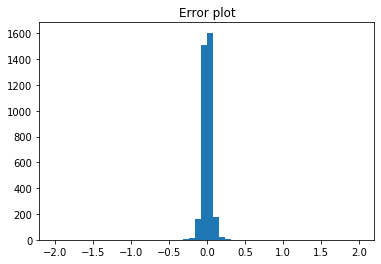

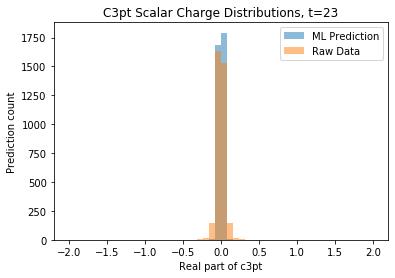

Prediction quality @ t=24: 0.9973387424954961


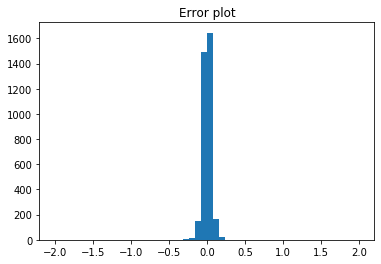

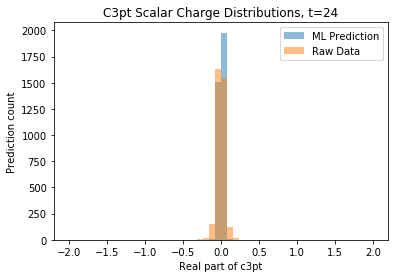

Prediction quality @ t=25: 0.9946565349450736


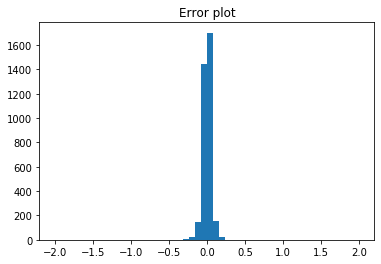

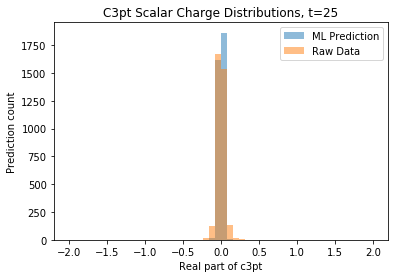

Prediction quality @ t=26: 0.9982096680651494


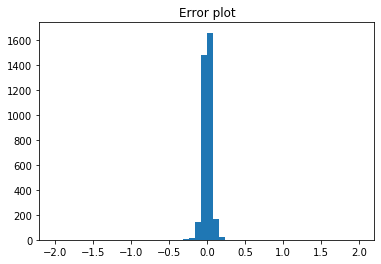

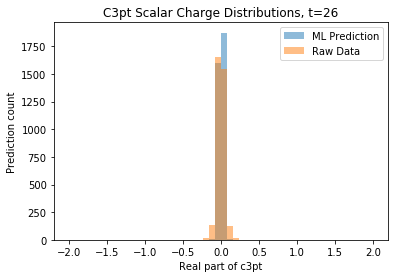

Prediction quality @ t=27: 1.010061543527673


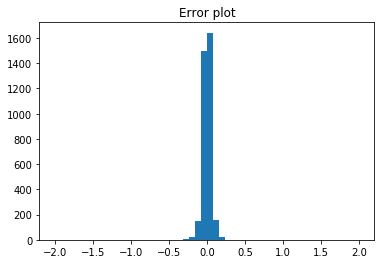

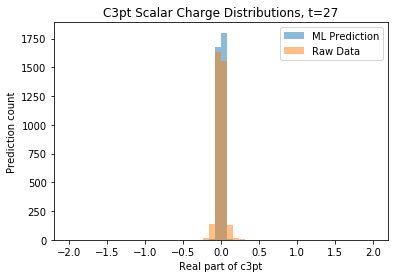

Prediction quality @ t=28: 0.9851044877619781


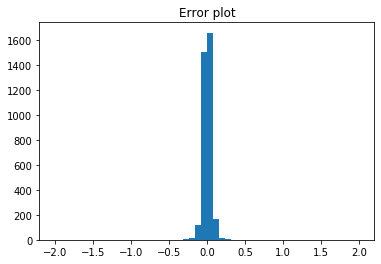

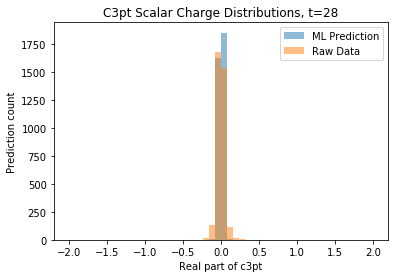

Prediction quality @ t=29: 0.9937192997466363


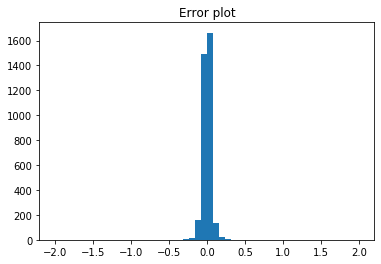

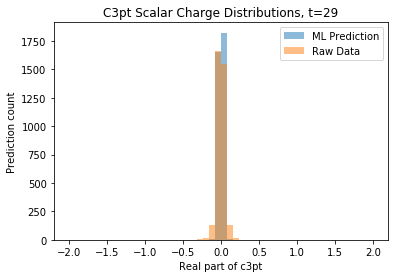

Prediction quality @ t=30: 0.9988246224620392


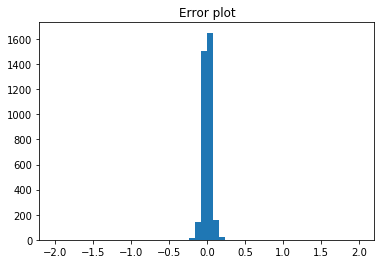

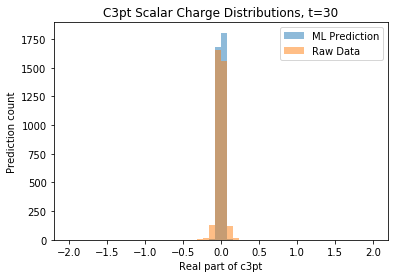

Prediction quality @ t=31: 0.9802799657152038


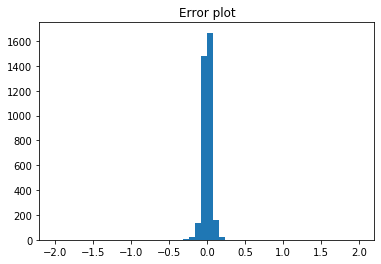

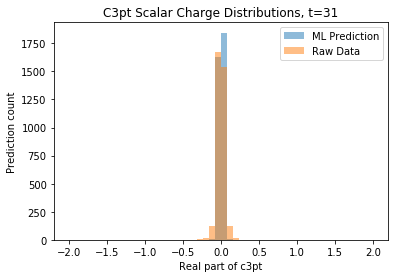

Prediction quality @ t=32: 0.9818153191556072


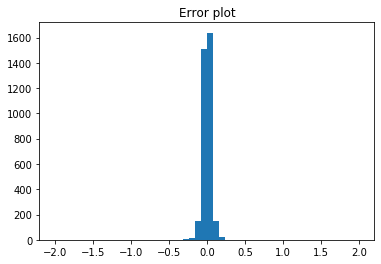

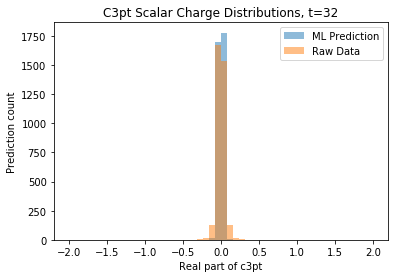

Prediction quality @ t=33: 0.9877137577741374


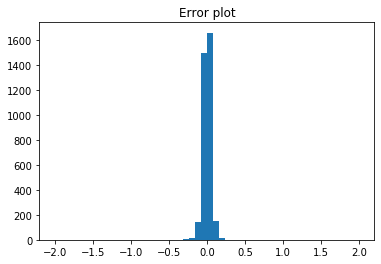

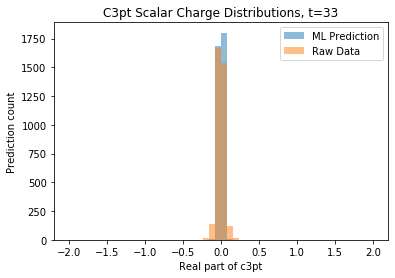

Prediction quality @ t=34: 0.9953184345291562


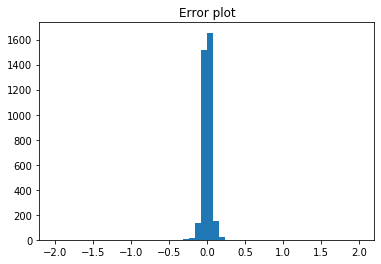

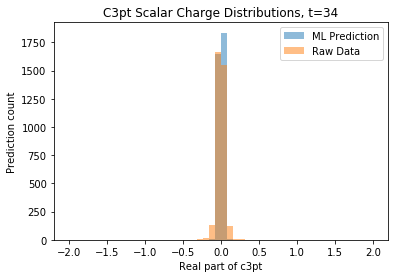

Prediction quality @ t=35: 0.9855918899264715


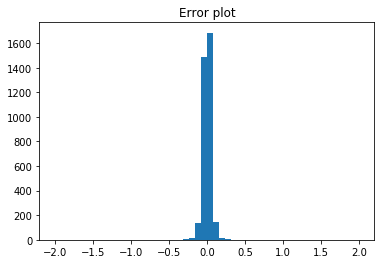

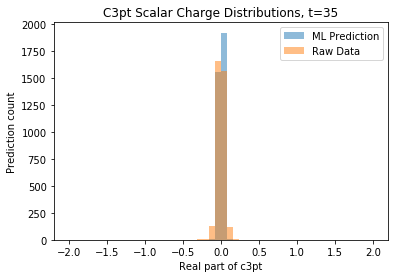

Prediction quality @ t=36: 0.9916278992102289


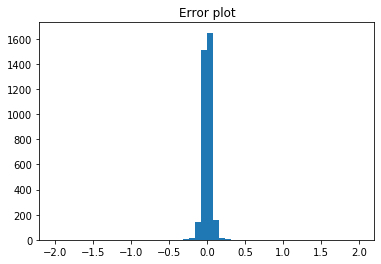

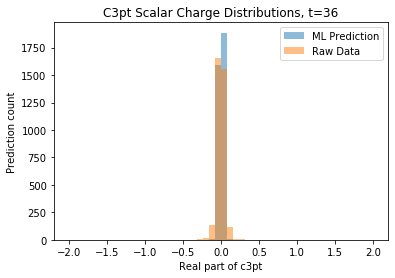

Prediction quality @ t=37: 0.9859524037700137


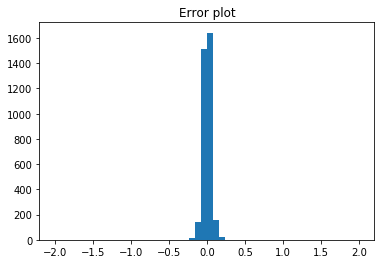

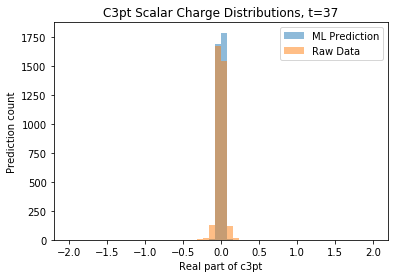

Prediction quality @ t=38: 0.9987975238202357


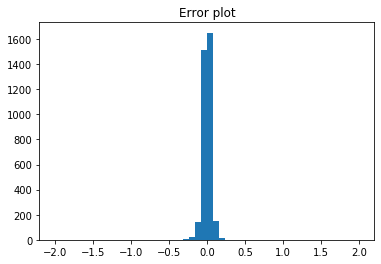

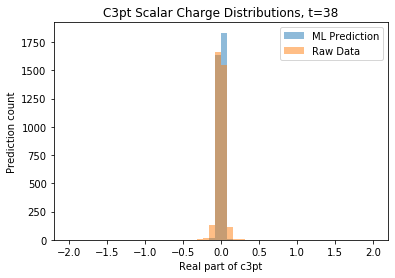

Prediction quality @ t=39: 0.988656218208325


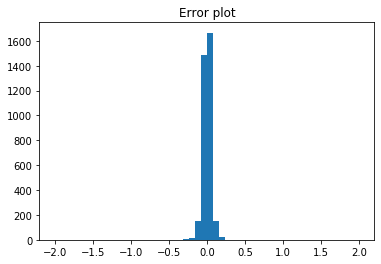

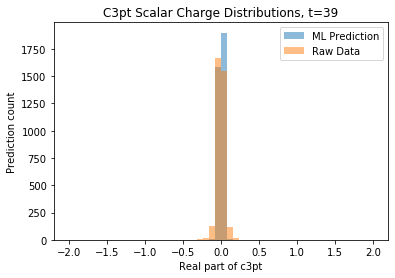

Prediction quality @ t=40: 1.0031251059893653


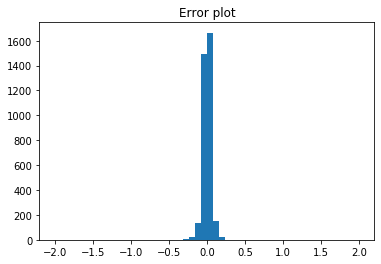

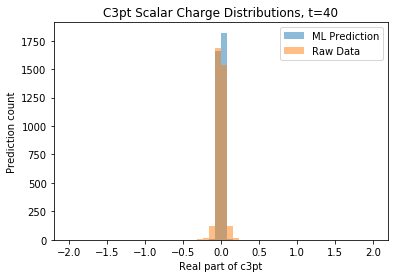

Prediction quality @ t=41: 0.9802852925224858


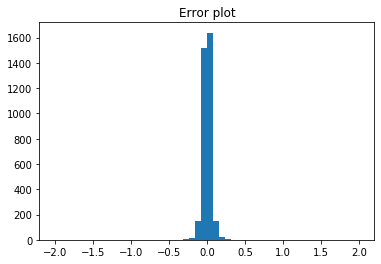

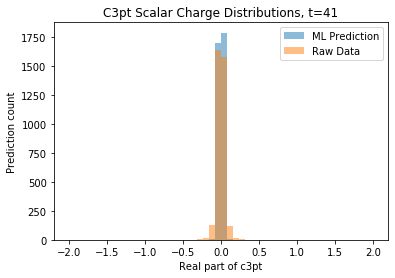

Prediction quality @ t=42: 0.9854561725508756


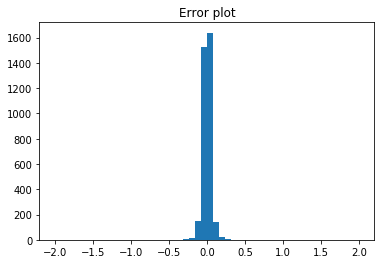

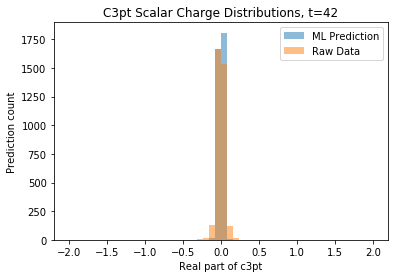

Prediction quality @ t=43: 1.0039140084183467


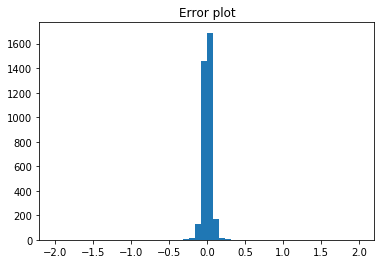

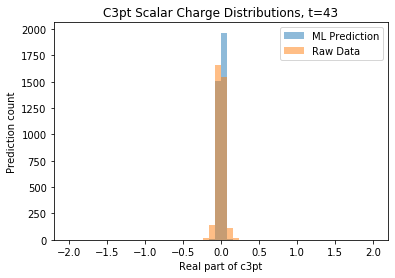

Prediction quality @ t=44: 0.9946511345822552


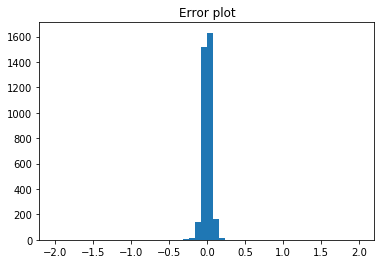

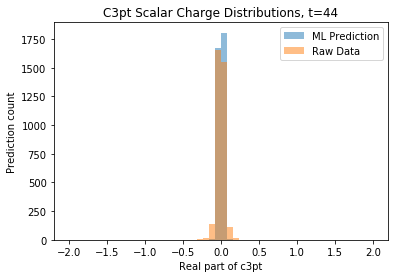

Prediction quality @ t=45: 1.001416012511294


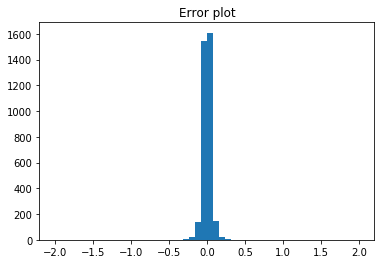

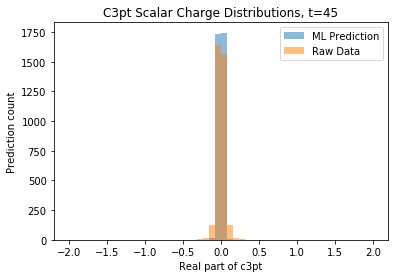

Prediction quality @ t=46: 0.9735229507869287


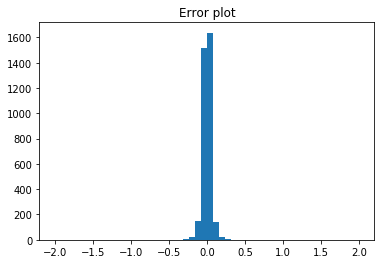

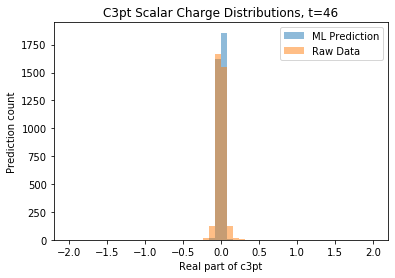

Prediction quality @ t=47: 1.021175576882841


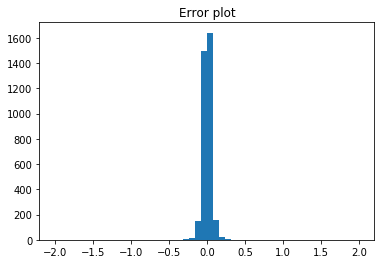

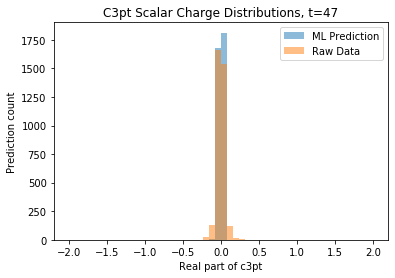

Prediction quality @ t=48: 0.9820066245720412


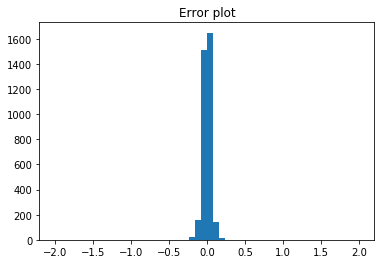

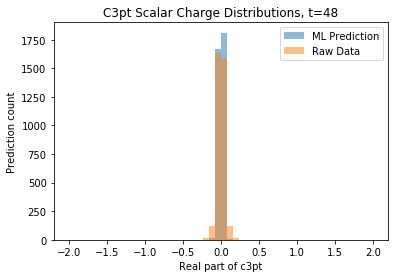

Prediction quality @ t=49: 1.0057322388931689


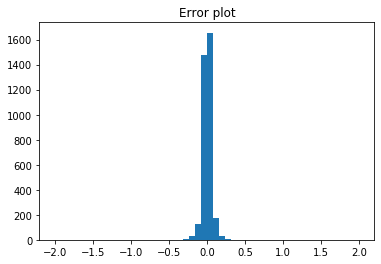

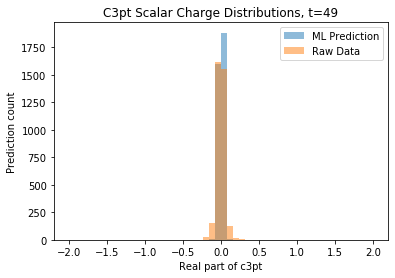

Prediction quality @ t=50: 0.996071056111147


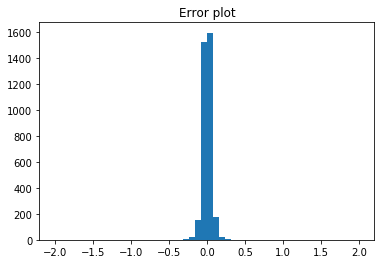

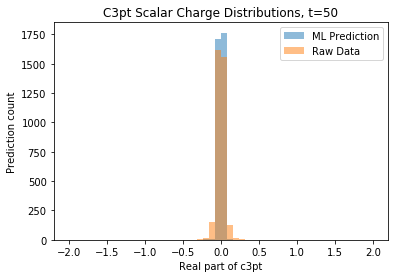

Prediction quality @ t=51: 0.9975447578585876


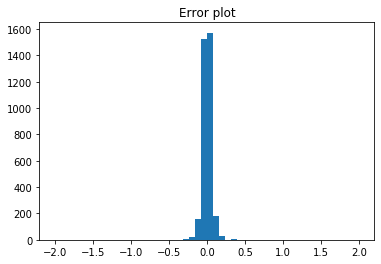

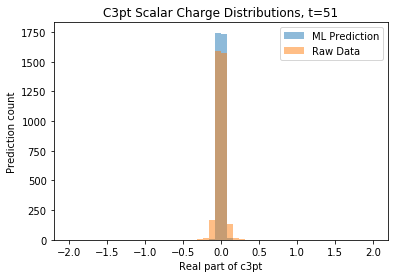

Prediction quality @ t=52: 1.001657377080422


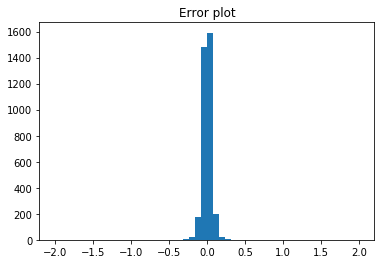

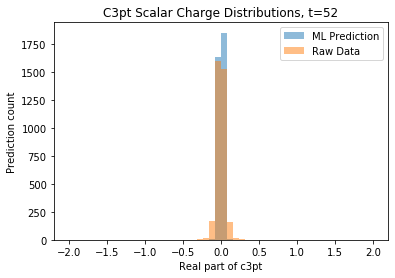

Prediction quality @ t=53: 1.008400865487321


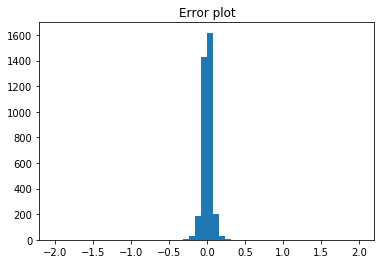

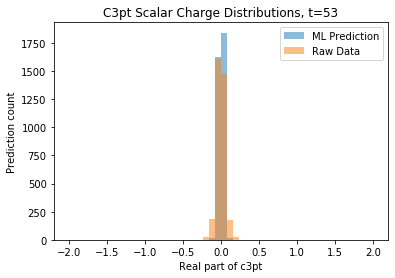

Prediction quality @ t=54: 1.039079722820552


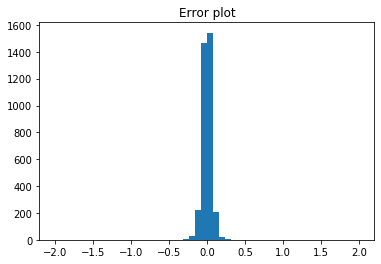

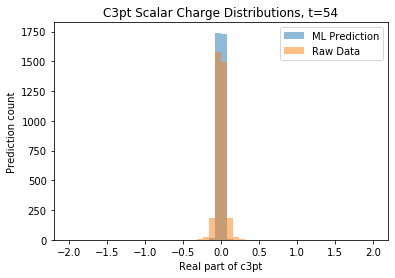

Prediction quality @ t=55: 1.014858870142403


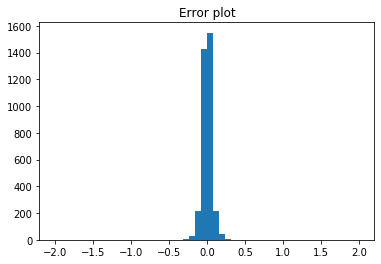

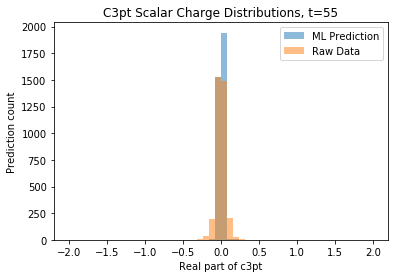

Prediction quality @ t=56: 0.9941773340123657


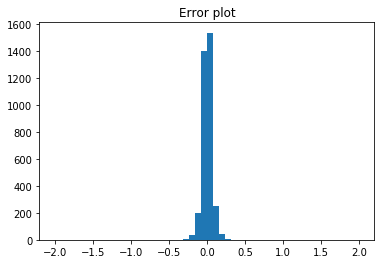

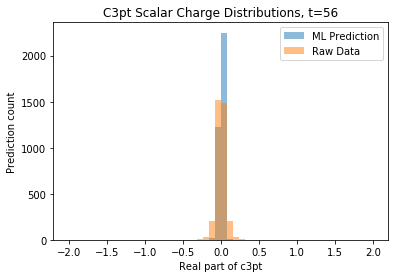

Prediction quality @ t=57: 1.0080032724928405


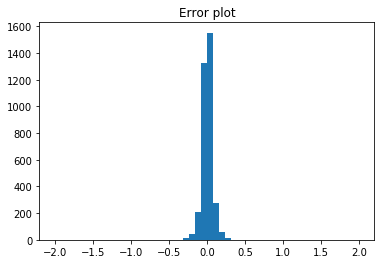

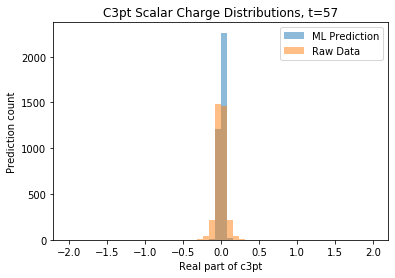

Prediction quality @ t=58: 0.9869620756591883


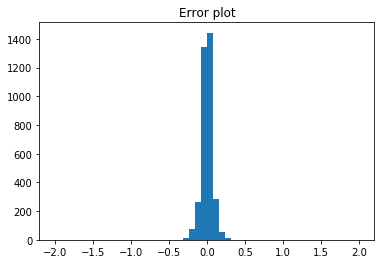

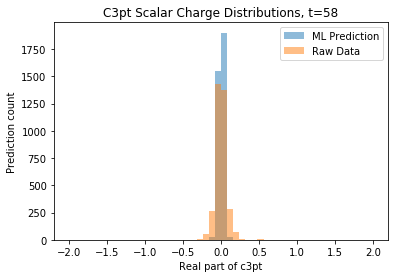

Prediction quality @ t=59: 1.0259708166426857


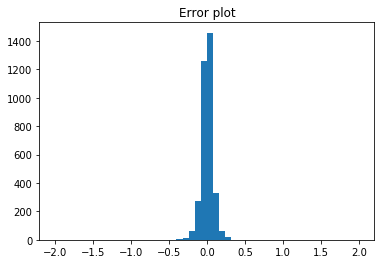

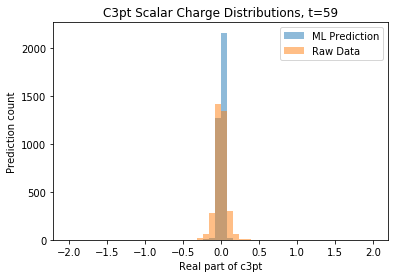

Prediction quality @ t=60: 1.0270260031286984


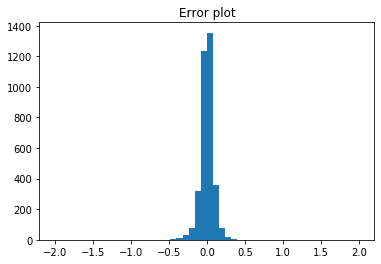

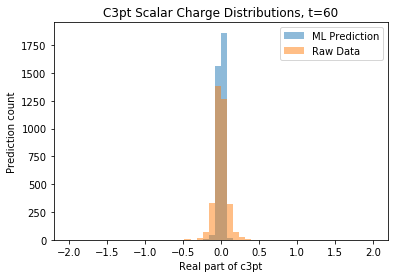

Prediction quality @ t=61: 1.041232480450527


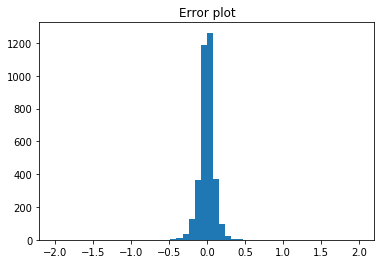

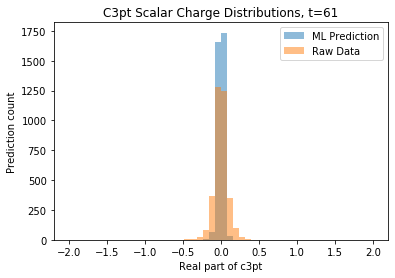

Prediction quality @ t=62: 1.0701542085645839


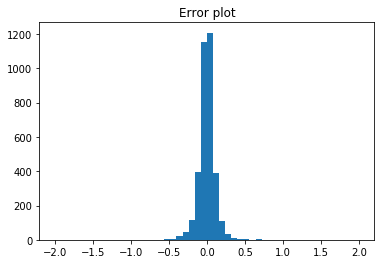

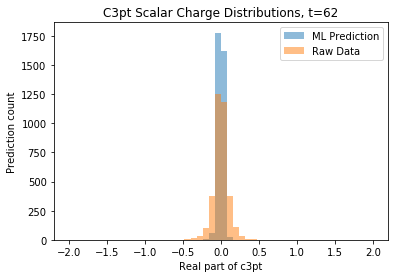

Prediction quality @ t=63: 0.7448588594151412


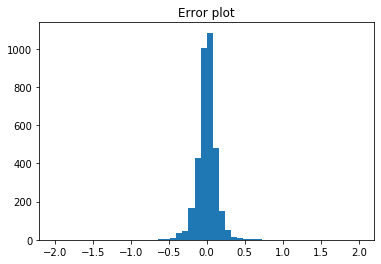

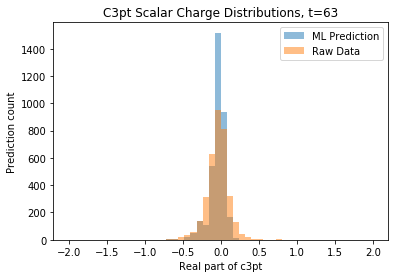

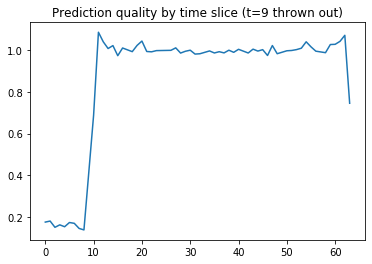

In [66]:
for t in range(64):
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test)):
        testImg = X_test[i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg])
        errors.append(pred_up[0] - testLabel_up)
        DM_samples.append(testLabel_up)
        ML_samples.append(pred_up[0])

    print("Prediction quality @ t=" + str(t) + ":", np.std(errors) / np.std(Y_train_up[t]))
    
    plt.hist(errors, bins=50, range=[-2, 2])
    plt.title("Error plot")
    plt.show()

    plt.hist(ML_samples, bins=50, range=[-2, 2], alpha=0.5)
    plt.hist(DM_samples, bins=50, range=[-2, 2], alpha=0.5)
    plt.legend(["ML Prediction", "Raw Data"])
    plt.xlabel("Real part of c3pt")
    plt.ylabel("Prediction count")
    plt.title("C3pt Scalar Charge Distributions, t=" + str(t))
    plt.show()

quals = []
for t in range(0, 64):
    if t % 8 == 1 and t != 1:
        quals.append(0)
        continue
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test)):
        testImg = X_test[i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg])
        errors.append(pred_up[0] - testLabel_up)
        ML_samples.append(pred_up[0])
        DM_samples.append(testLabel_up)

    quals.append(np.std(errors) / np.std(Y_train_up[t]))
    
for i in range(9, 64, 8):
    quals[i] = (quals[i-1] + quals[i + 1]) / 2

plt.plot(list(range(64)), quals)
plt.title("Prediction quality by time slice (t=9 thrown out)")
plt.show()

0.1794303980810436


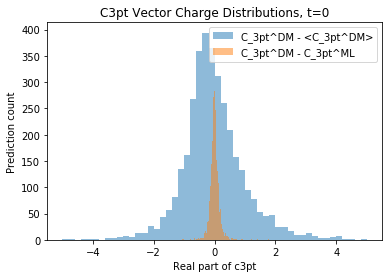

0.1889019822525603


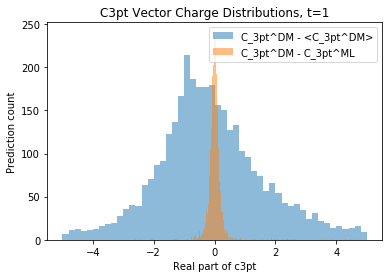

0.15623056805170818


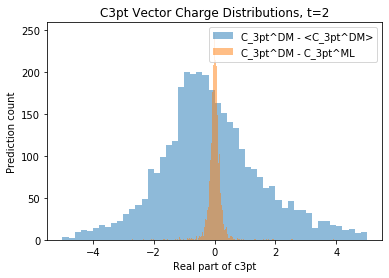

0.17021428295306523


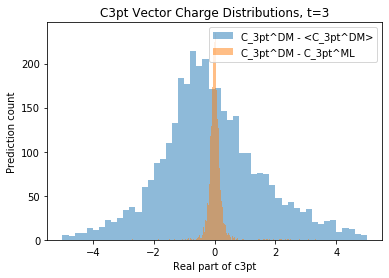

0.1589885378207128


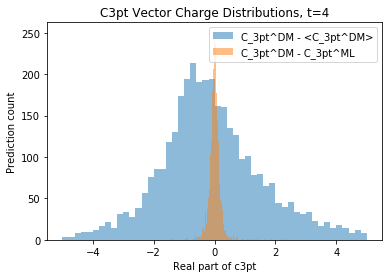

0.1835829762028031


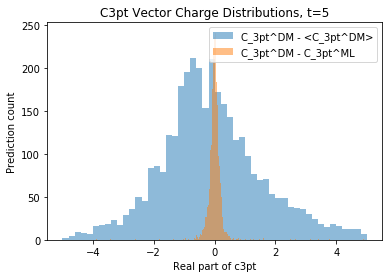

0.17927422961401301


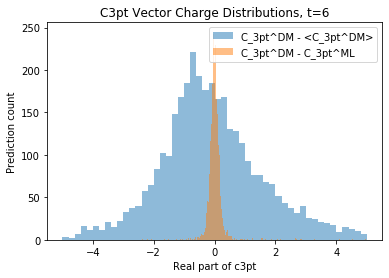

0.1525105873092044


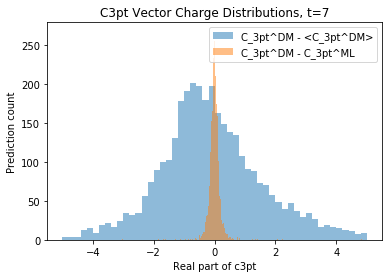

0.14566636822215465


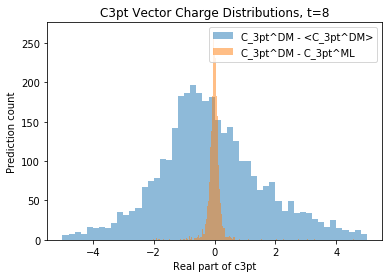

0.495606084968651


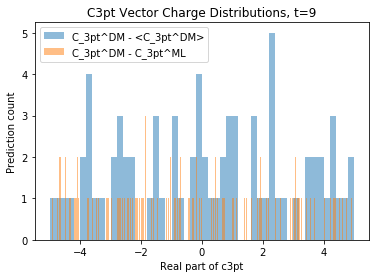

0.7869270927145017


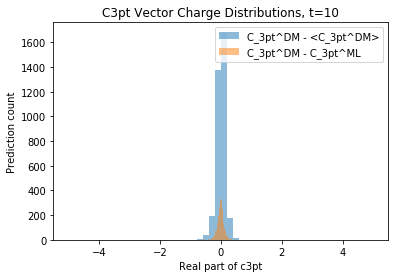

1.040398158368345


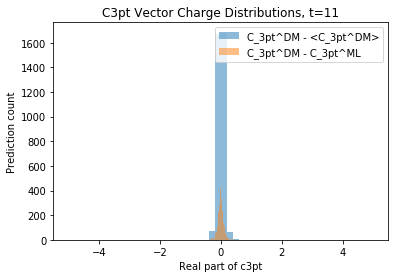

1.05654896839484


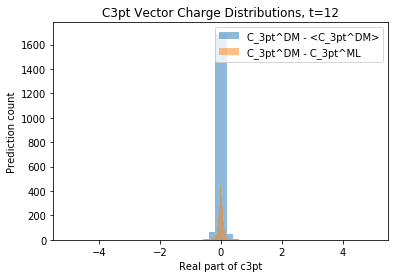

1.0700461168421769


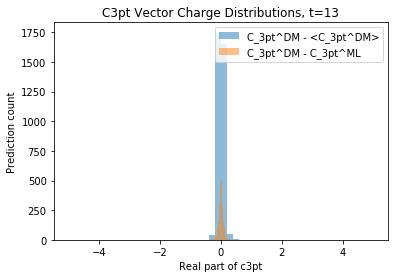

1.0429584836354067


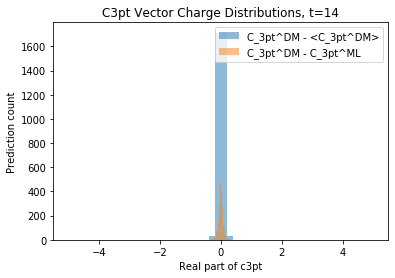

1.0617238894823595


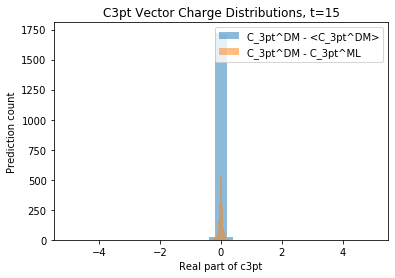

1.0511649214468266


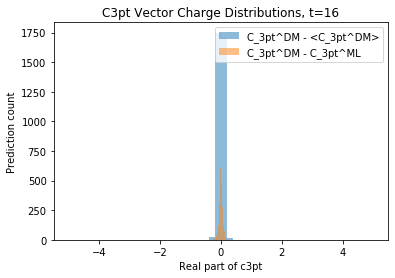

1.0689747663052132


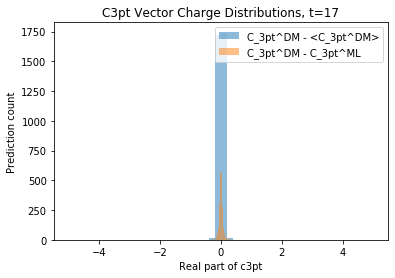

1.0535674893328653


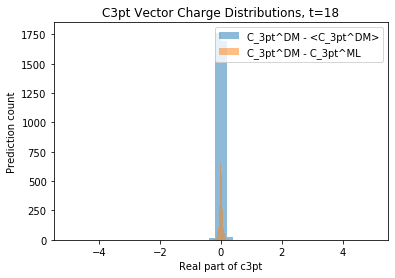

1.0586782166835098


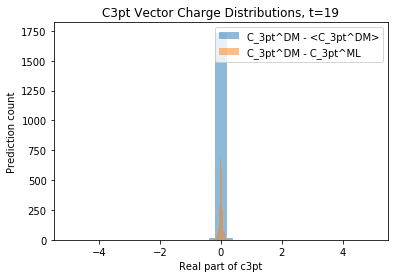

1.050079401048374


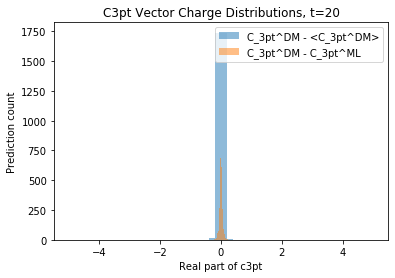

1.0532114212950043


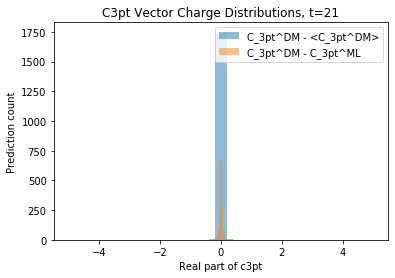

1.0533988061996533


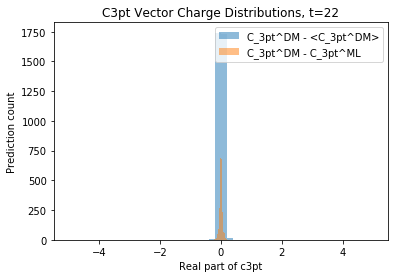

1.0694626437247698


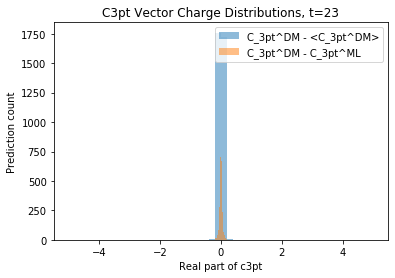

1.0532222454231073


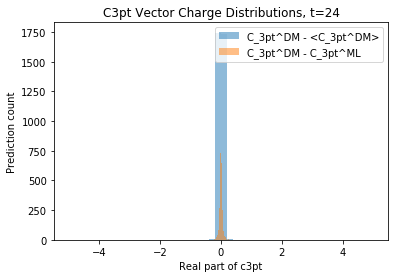

1.0687566072460601


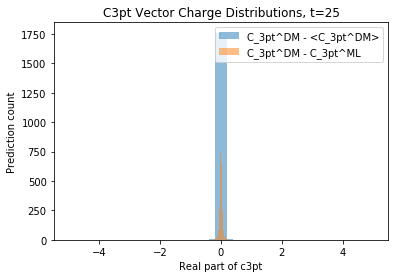

1.0637988331577481


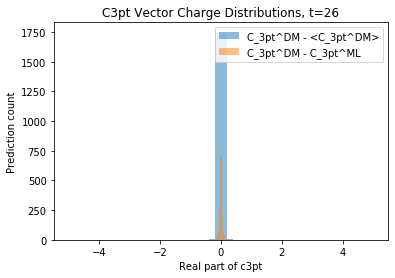

1.063569123076209


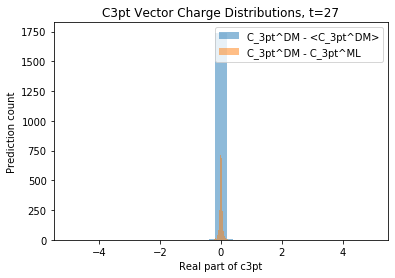

1.0581093787047986


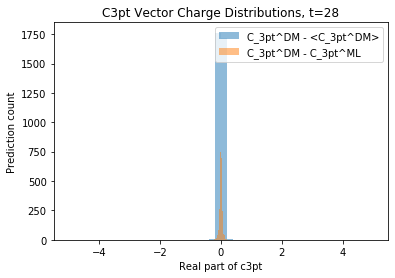

1.0641384561980016


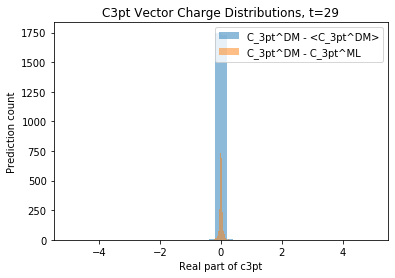

1.0572419157183972


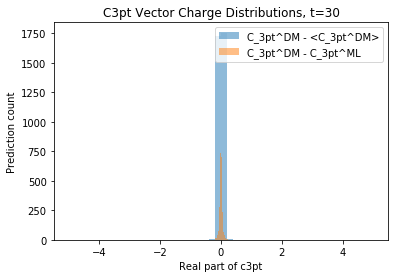

1.0671961245428998


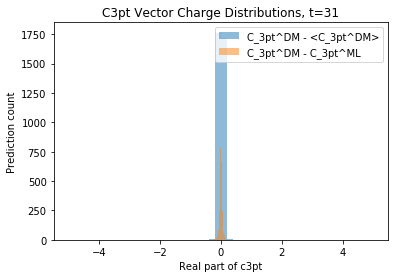

1.0574661101299172


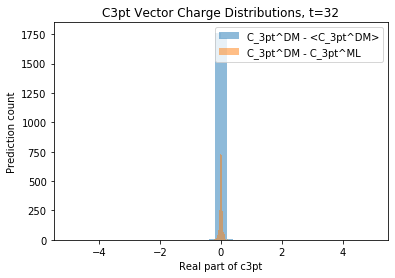

1.0562032671896806


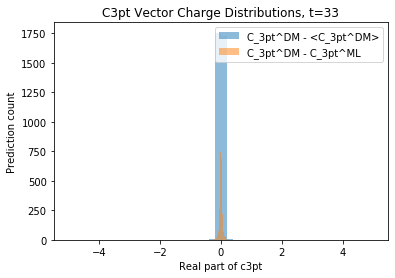

1.0655942890574186


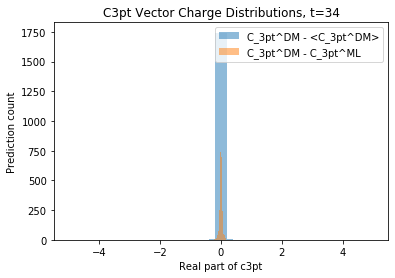

1.0571417447489437


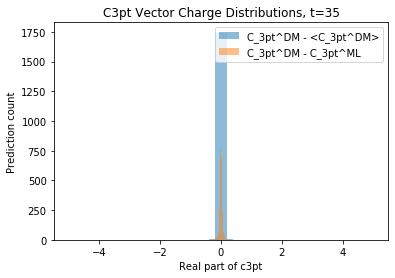

1.0635125102476348


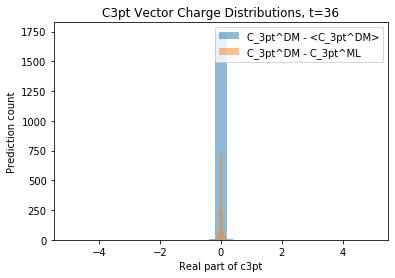

1.0564733675091564


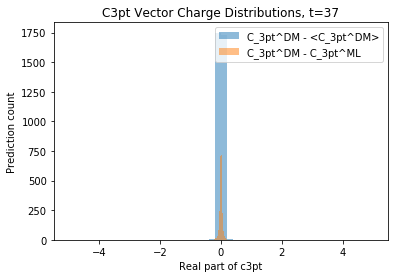

1.064969876086119


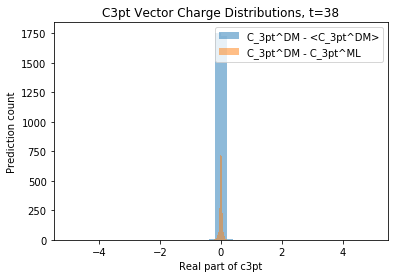

1.0749605455322686


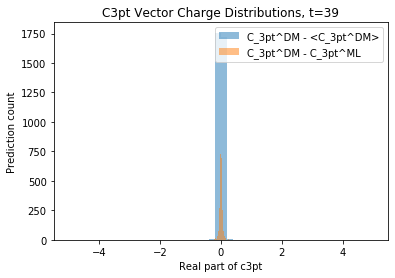

1.0603219039889002


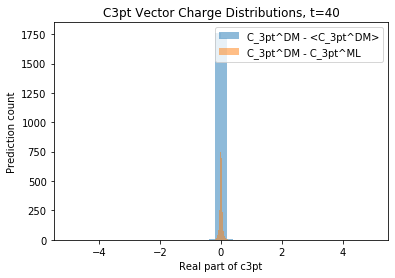

1.0571551278489568


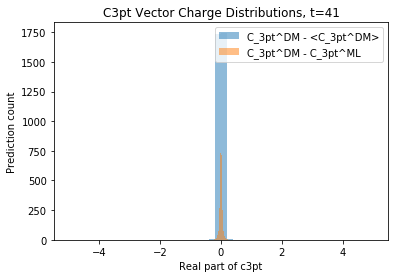

1.062174216802788


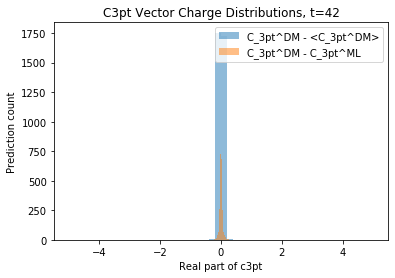

1.0685242477563768


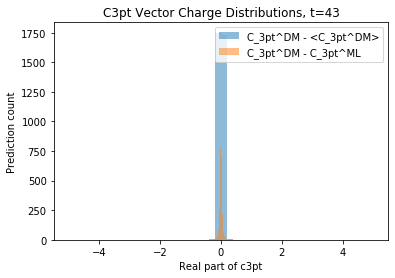

1.0620930974260658


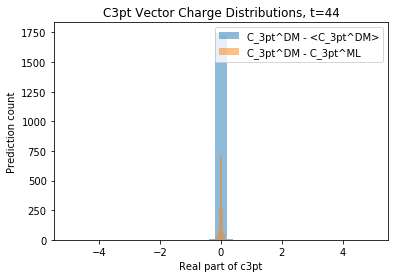

1.065005120689603


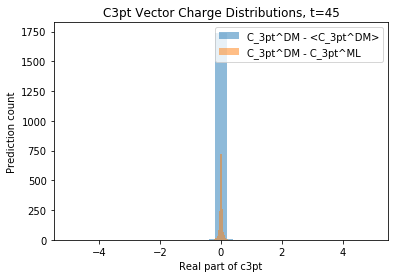

1.0638688056003767


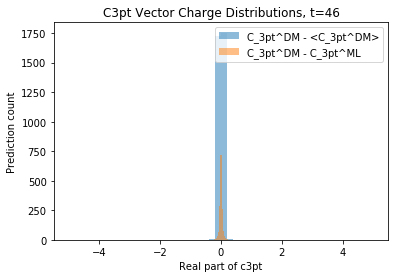

1.0586063009392408


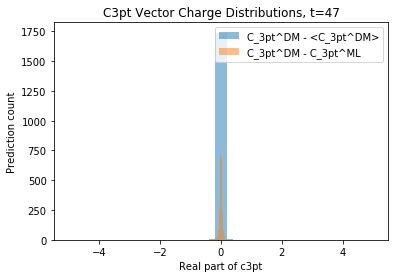

1.055459886886012


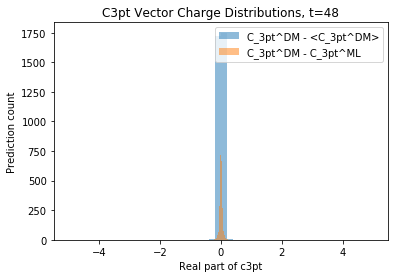

1.0631629424237867


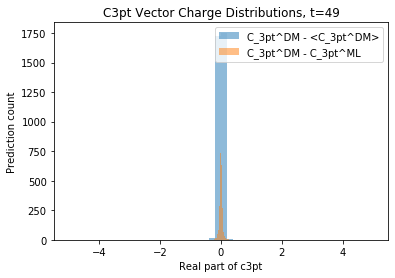

1.061435550800909


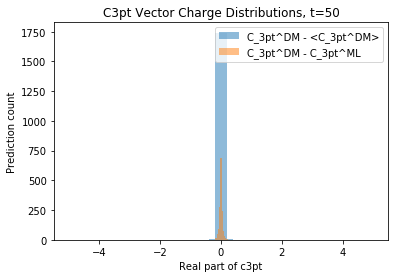

1.0665882783865819


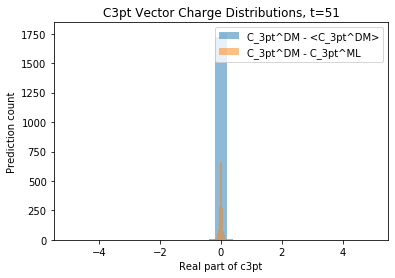

1.0580062503492262


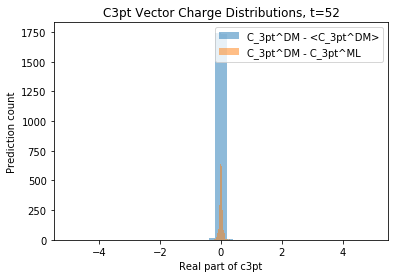

1.0600026378626235


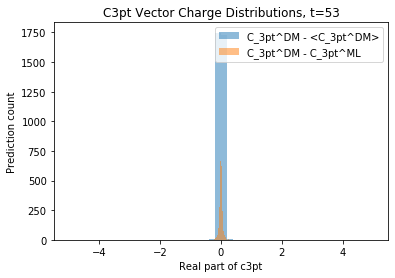

1.0508356620151622


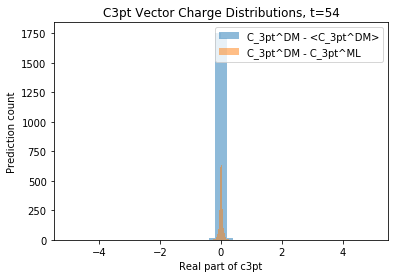

1.0545670862075012


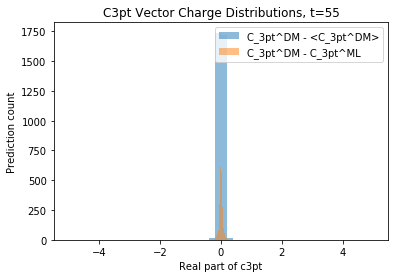

1.0526095378820661


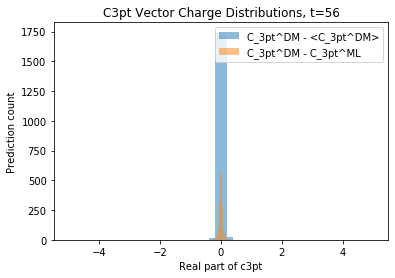

1.0475758116064224


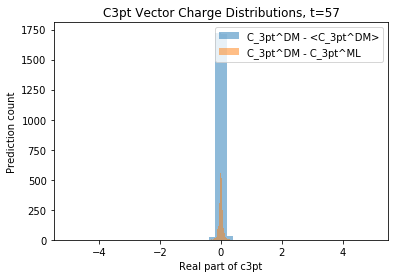

1.0442641179003072


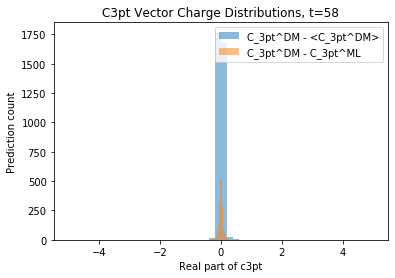

1.0423715613381503


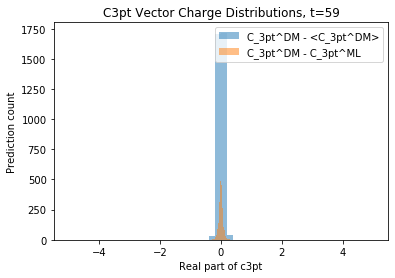

1.063011264909816


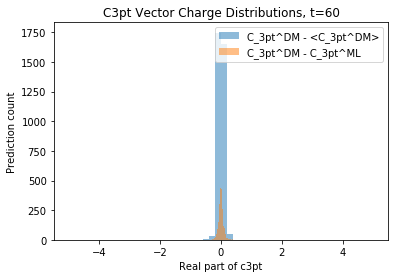

1.0710927023660013


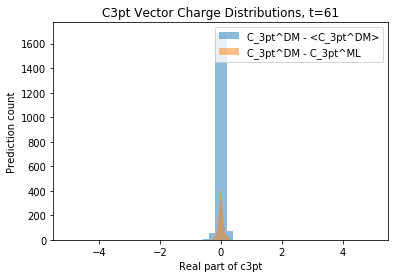

1.0423245643516077


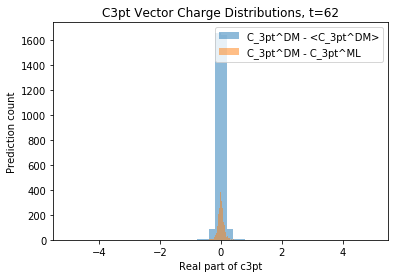

0.8329809464781707


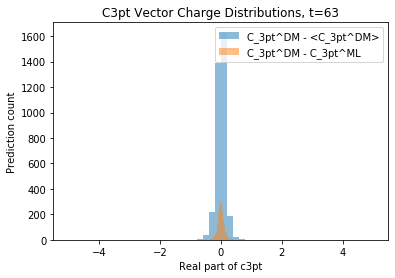

In [67]:
for t in range(64):
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test)):
        testImg = X_test[i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg])
        errors.append(testLabel_up - pred_up[0])
        DM_samples.append(testLabel_up)
        
    DM_avg = np.average(np.array(DM_samples))
    for i in range(len(DM_samples)):
        DM_samples[i] -= DM_avg
        
    print(np.std(errors) / np.std(Y_test_up[t]))

    plt.hist(DM_samples, bins=50, range=[-5, 5], alpha=0.5)
    plt.hist(errors, bins=500, range=[-5, 5], alpha=0.5)
    plt.legend(["C_3pt^DM - <C_3pt^DM>", "C_3pt^DM - C_3pt^ML"])
    plt.xlabel("Real part of c3pt")
    plt.ylabel("Prediction count")
    plt.title("C3pt Vector Charge Distributions, t=" + str(t))
    plt.show()

In [68]:
for t in range(64):
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test)):
        testImg = X_test[i]
        testLabel_down = Y_test_down[t][i]
        testLabel_up = Y_test_up[t][i]
        pred_down = gbr_down[t].predict([testImg])
        pred_up = gbr_up[t].predict([testImg])
        DM_samples.append(testLabel_up - testLabel_down)
        ML_samples.append(pred_up - pred_down)
        
    DM_avg = np.average(np.array(DM_samples))
    ML_avg = np.average(np.array(ML_samples))
    
    print("Relative Difference at t=", t, ":", (DM_avg - ML_avg) / DM_avg)

Relative Difference at t= 0 : 0.009346788508325422
Relative Difference at t= 1 : 0.03237594988243824
Relative Difference at t= 2 : 0.017620460415600947
Relative Difference at t= 3 : 0.02854754067491581
Relative Difference at t= 4 : -0.012666228215756282
Relative Difference at t= 5 : 0.0566728604170238
Relative Difference at t= 6 : 0.017533693713804775
Relative Difference at t= 7 : 0.005875301191718865
Relative Difference at t= 8 : -0.01448972646554424
Relative Difference at t= 9 : -0.16344366503502403
Relative Difference at t= 10 : 0.15918535439623593
Relative Difference at t= 11 : 1.3830372321836835
Relative Difference at t= 12 : 2.6150530615679672
Relative Difference at t= 13 : -2.814304914801479
Relative Difference at t= 14 : 2.9749339569193194
Relative Difference at t= 15 : 2.8980581100647558
Relative Difference at t= 16 : -61.67233636396834
Relative Difference at t= 17 : 1.5168818729981683
Relative Difference at t= 18 : 4.904381487224542
Relative Difference at t= 19 : 2.4517584965

## Axial Charge Prediction With Bias Correction

In [134]:
labelFrac = 0.2
bcFrac = 0.4

labelEnd = int(len(labels_V_up[0]) * labelFrac)
bcEnd = int(len(labels_V_up[0]) * (labelFrac + bcFrac))

X_train, Y_train_up, Y_train_down = features[:labelEnd], labels_A_up[:, :labelEnd], labels_A_down[:, :labelEnd]
X_bc, Y_bc_up, Y_bc_down = features[labelEnd:bcEnd], labels_A_up[:, labelEnd:bcEnd], labels_A_down[:, labelEnd:bcEnd]
X_test, Y_test_up, Y_test_down = features[bcEnd:], labels_A_up[:, bcEnd:], labels_A_down[:, bcEnd:]

samps = 10

gbr_up = list(range(samps))
gbr_down = list(range(samps))
biasCrxn_up = list(range(samps))
biasCrxn_down = list(range(samps))

for i in range(samps):
    gbr_up[i] = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
    gbr_up[i].fit(X_train, Y_train_up[i])
    up_bc_pred = gbr_up[i].predict(X_bc)
    biasCrxn_up[i] = np.average(Y_bc_up[i] - up_bc_pred)
    print("Up bias correction for t=", i, ":", biasCrxn_up[i])
    
    gbr_down[i] = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
    gbr_down[i].fit(X_train, Y_train_down[i])
    down_bc_pred = gbr_down[i].predict(X_bc)
    biasCrxn_down[i] = np.average(Y_bc_down[i] - down_bc_pred)
    print("Down bias correction for t=", i, ":", biasCrxn_down[i])


Up bias correction for t= 0 : -0.029834562944470216
Down bias correction for t= 0 : -0.0012953468600100395
Up bias correction for t= 1 : -0.009006801715685972
Down bias correction for t= 1 : -0.013084276613765468
Up bias correction for t= 2 : -0.013469647922488165
Down bias correction for t= 2 : -0.009662305342766077
Up bias correction for t= 3 : 0.004672111738777894
Down bias correction for t= 3 : -0.0074941427047160725
Up bias correction for t= 4 : -0.0008237844887335993
Down bias correction for t= 4 : 0.003811307618939845
Up bias correction for t= 5 : -0.028941239413999575
Down bias correction for t= 5 : 0.0039788372827413016
Up bias correction for t= 6 : -0.01195085888835286
Down bias correction for t= 6 : -0.010276875491894278
Up bias correction for t= 7 : 0.02064825695221666
Down bias correction for t= 7 : -2.1302563038016097e-06
Up bias correction for t= 8 : 0.038137174716758995
Down bias correction for t= 8 : 0.004786786072923566
Up bias correction for t= 9 : 4.912182955408708


Prediction quality @ t=0: 1.068723214216442


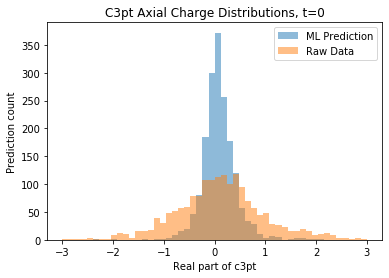

Prediction quality @ t=1: 0.9541265495304119


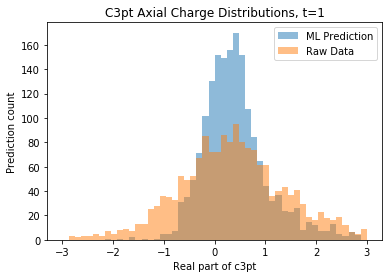

Prediction quality @ t=2: 1.0296794147145405


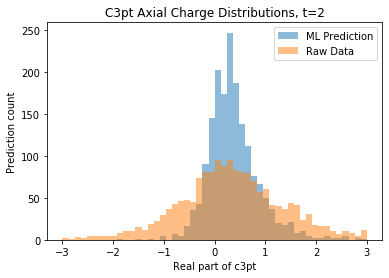

Prediction quality @ t=3: 1.1108079319090665


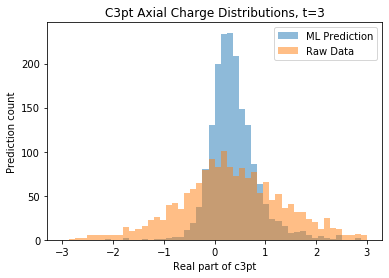

Prediction quality @ t=4: 1.1106134723638192


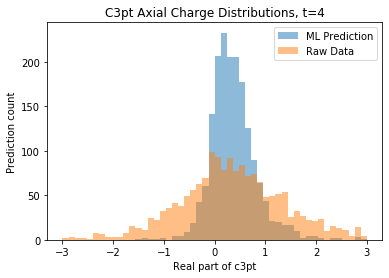

Prediction quality @ t=5: 1.0518065590930568


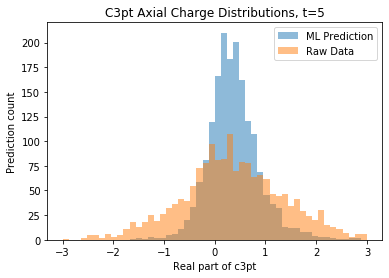

Prediction quality @ t=6: 0.9876083782828405


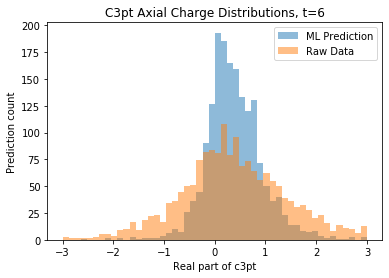

Prediction quality @ t=7: 0.9440369021236307


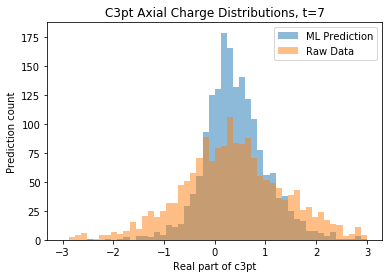

Prediction quality @ t=8: 0.8367018231500036


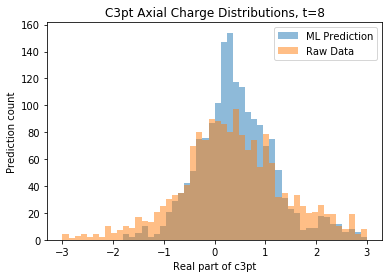

Prediction quality @ t=9: 1.0089497362597397


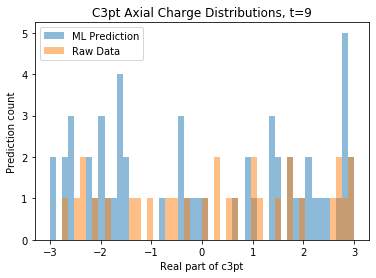

0.07623993141484327
0.02682391834574943
0.01994123532299663
0.05580918951178987
0.14505506623700037
0.08157610111943892
-0.039663716952889394
-0.06934693728194119
-0.0021372430625130057
-26.939418454924194


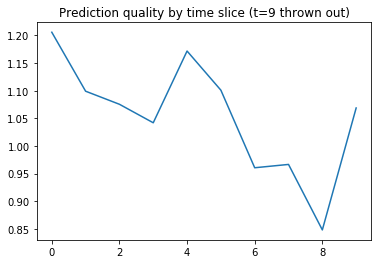

In [136]:
for t in range(samps):
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test)):
        testImg = X_test[i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg])[0] + biasCrxn_up[t]
        errors.append(pred_up - testLabel_up)
        ML_samples.append(pred_up)
        DM_samples.append(testLabel_up)

    print("Prediction quality @ t=" + str(t) + ":", np.std(errors) / np.std(Y_train_up[t]))

    plt.hist(ML_samples, bins=50, range=[-3, 3], alpha=0.5)
    plt.hist(DM_samples, bins=50, range=[-3, 3], alpha=0.5)
    plt.legend(["ML Prediction", "Raw Data"])
    plt.xlabel("Real part of c3pt")
    plt.ylabel("Prediction count")
    plt.title("C3pt Axial Charge Distributions, t=" + str(t))
    plt.show()

quals = []
for t in range(0, samps):
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test[t])):
        testImg = X_test[i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg])[0]  + biasCrxn_up[t]
        errors.append(pred_up - testLabel_up)
        DM_samples.append(testLabel_up)
        ML_samples.append(pred_up)
        
    avgDiff = (sum(DM_samples) - sum(ML_samples)) / len(DM_samples)
    print(avgDiff)

    quals.append(np.std(errors) / np.std(Y_train_up[t]))
    
for i in range(9, samps - 1, 8):
    quals[i] = (quals[i-1] + quals[i + 1]) / 2

plt.plot(list(range(samps)), quals)
plt.title("Prediction quality by time slice (t=9 thrown out)")
plt.show()

1.0225613118356942



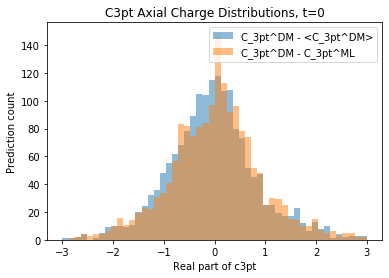

0.8430849922347765



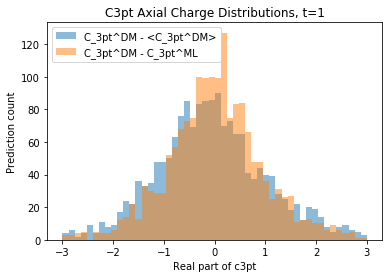

0.91651448757332



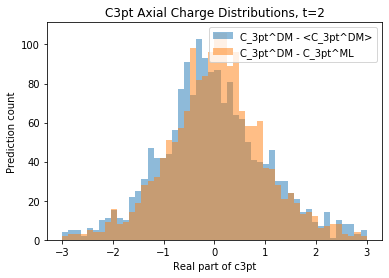

0.9734119957693718



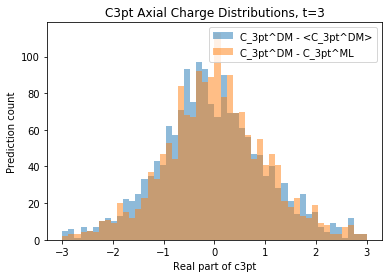

0.9646156639416584



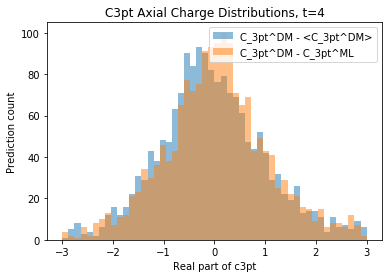

0.9695407931146093



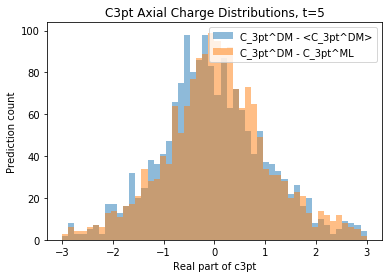

0.9512973375121806



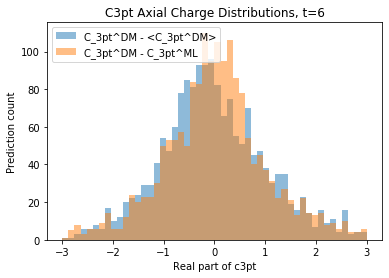

0.9106468304561979



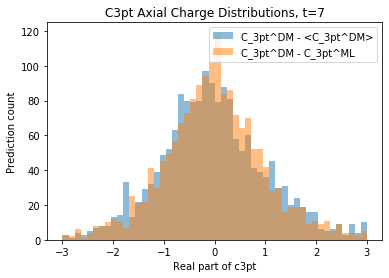

0.806126791667692



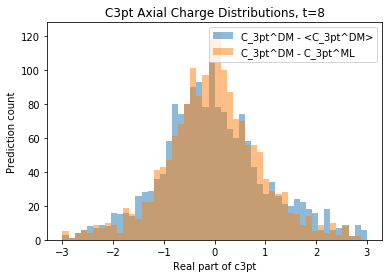

0.963163534941498



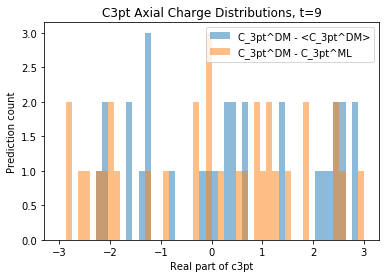

In [137]:
for t in range(samps):
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test)):
        testImg = X_test[i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg])[0]  + biasCrxn_up[t]
        errors.append(testLabel_up - pred_up)
        DM_samples.append(testLabel_up)
        
    DM_avg = np.average(np.array(DM_samples))
    for i in range(len(DM_samples)):
        DM_samples[i] -= DM_avg
        
    print(np.std(errors) / np.std(Y_test_up[t]))
    print()

    plt.hist(DM_samples, bins=50, range=[-3, 3], alpha=0.5)
    plt.hist(errors, bins=50, range=[-3, 3], alpha=0.5)
    plt.legend(["C_3pt^DM - <C_3pt^DM>", "C_3pt^DM - C_3pt^ML"])
    plt.xlabel("Real part of c3pt")
    plt.ylabel("Prediction count")
    plt.title("C3pt Axial Charge Distributions, t=" + str(t))
    plt.show()

0.6466497726085838



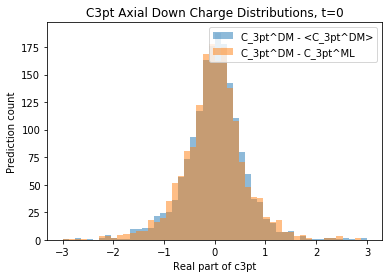

0.5264634828914313



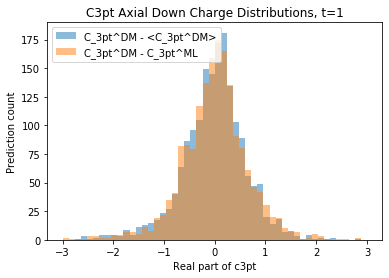

0.5795390202373469



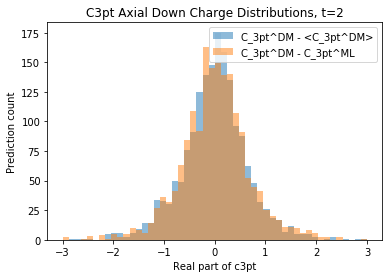

0.5796141346807194



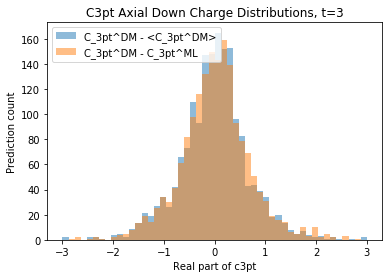

0.5761486687253627



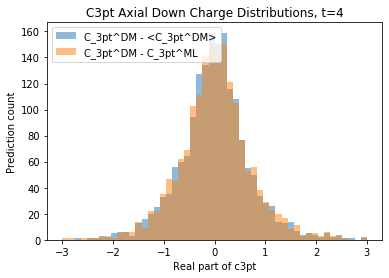

0.6001934095064119



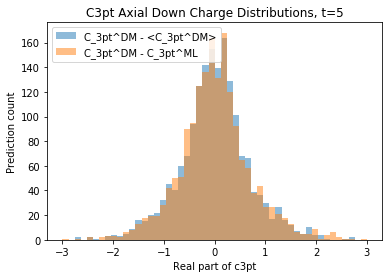

0.5973317493213527



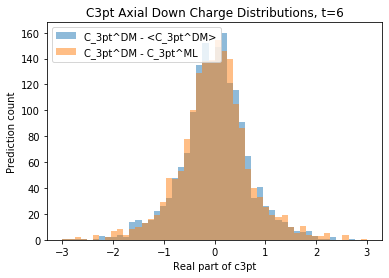

0.5662585693750302



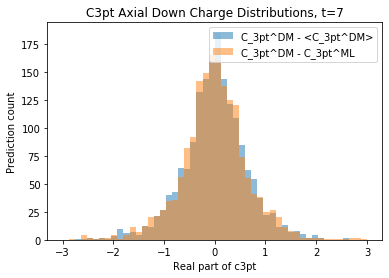

0.5030101714144698



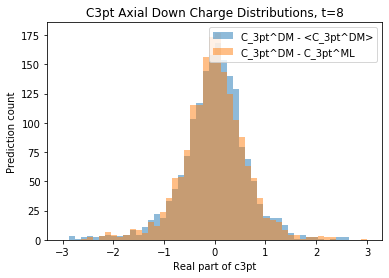

0.64332876577239



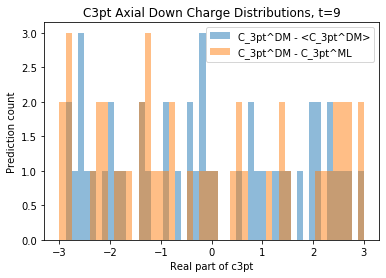

In [138]:
for t in range(samps):
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test)):
        testImg = X_test[i]
        testLabel_down = Y_test_down[t][i]
        pred_down = gbr_down[t].predict([testImg])[0] +  + biasCrxn_down[t]
        errors.append(testLabel_down - pred_down)
        DM_samples.append(testLabel_down)
        
    DM_avg = np.average(np.array(DM_samples))
    for i in range(len(DM_samples)):
        DM_samples[i] -= DM_avg
        
    print(np.std(errors) / np.std(Y_test_up[t]))
    print()

    plt.hist(DM_samples, bins=50, range=[-3, 3], alpha=0.5)
    plt.hist(errors, bins=50, range=[-3, 3], alpha=0.5)
    plt.legend(["C_3pt^DM - <C_3pt^DM>", "C_3pt^DM - C_3pt^ML"])
    plt.xlabel("Real part of c3pt")
    plt.ylabel("Prediction count")
    plt.title("C3pt Axial Down Charge Distributions, t=" + str(t))
    plt.show()

Relative Difference at t= 1 : 0.03521709514866226
Relative Difference at t= 2 : -0.017453984271659336
Relative Difference at t= 3 : 0.03948768690671054
Relative Difference at t= 4 : 0.06344902503059702
Relative Difference at t= 5 : 0.006762394355443802
Relative Difference at t= 6 : 0.04143586604497477
Relative Difference at t= 7 : 0.04758551381290614
Relative Difference at t= 8 : 0.02905805511351864


Text(0.5, 1.0, 'Non Bias Corrected Axial Prediction Comparisons')

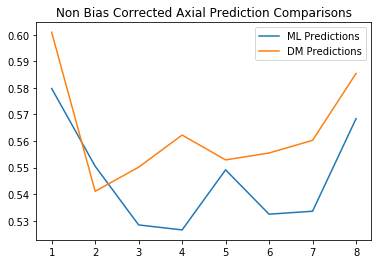

In [146]:
ML_pts = []
DM_pts = []
for t in range(1, 9, 1):
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test)):
        testImg = X_test[i]
        testLabel_down = Y_test_down[t][i]
        testLabel_up = Y_test_up[t][i]
        pred_down = gbr_down[t].predict([testImg])[0]# + biasCrxn_down[t]
        pred_up = gbr_up[t].predict([testImg])[0]# + biasCrxn_up[t]
        DM_samples.append(testLabel_up - testLabel_down)
        ML_samples.append(pred_up - pred_down)
        
    DM_avg = np.average(np.array(DM_samples))
    ML_avg = np.average(np.array(ML_samples))
    
    print("Relative Difference at t=", t, ":", (DM_avg - ML_avg) / DM_avg)
    ML_pts.append(ML_avg)
    DM_pts.append(DM_avg)

plt.plot(list(range(1, 9)), ML_pts)
plt.plot(list(range(1, 9)), DM_pts)
plt.legend(["ML Predictions", "DM Predictions"])
plt.title("Non Bias Corrected Axial Prediction Comparisons")